<font size="15">Project: Air Quality Index: 5 Days Relative Mortality </font>

In [1]:
#### Packages

import zipfile
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statistics import mean
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import random
import matplotlib.dates as mdates
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [20]:
### first view of data

airdata = pd.read_csv("/Users/jerry/Downloads/AirQualityUCI/AirQualityUCI.csv", sep = ";")

def missing_table(input):
    total_temp = input.isnull().sum().sort_values(ascending = False)
    percent_miss_temp = (input.isnull().sum() / (len(airdata))*100).sort_values(ascending = False)
    airdata_missing = pd.concat([total_temp, percent_miss_temp], axis = 1 ,keys = ['total_missing', 'percent_missing(%)']) 
    return airdata_missing

display(missing_table(airdata))
airdata.head(20)


total_missing  percent_missing(%)
Unnamed: 16             9471          100.000000
Unnamed: 15             9471          100.000000
NOx(GT)                  114            1.203674
Time                     114            1.203674
CO(GT)                   114            1.203674
PT08.S1(CO)              114            1.203674
NMHC(GT)                 114            1.203674
C6H6(GT)                 114            1.203674
PT08.S2(NMHC)            114            1.203674
PT08.S3(NOx)             114            1.203674
NO2(GT)                  114            1.203674
PT08.S4(NO2)             114            1.203674
PT08.S5(O3)              114            1.203674
T                        114            1.203674
RH                       114            1.203674
AH                       114            1.203674
Date                     114            1.203674

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
0   10/03/2004  18.00.00    2,6       1360.0     150.0     11,9   
1   10/03/2004  19.00.00      2       1292.0     112.0      9,4   
2   10/03/2004  20.00.00    2,2       1402.0      88.0      9,0   
3   10/03/2004  21.00.00    2,2       1376.0      80.0      9,2   
4   10/03/2004  22.00.00    1,6       1272.0      51.0      6,5   
5   10/03/2004  23.00.00    1,2       1197.0      38.0      4,7   
6   11/03/2004  00.00.00    1,2       1185.0      31.0      3,6   
7   11/03/2004  01.00.00      1       1136.0      31.0      3,3   
8   11/03/2004  02.00.00    0,9       1094.0      24.0      2,3   
9   11/03/2004  03.00.00    0,6       1010.0      19.0      1,7   
10  11/03/2004  04.00.00   -200       1011.0      14.0      1,3   
11  11/03/2004  05.00.00    0,7       1066.0       8.0      1,1   
12  11/03/2004  06.00.00    0,7       1052.0      16.0      1,6   
13  11/03/2004  07.00.00    1,1       1144.0      29.0      3,2   
14  11/03/2004  08.00.00      2       1333.0      64.0      8,0   
15  11/03/2004  09.00.00    2,2       1351.0      87.0      9,5   
16  11/03/2004  10.00.00    1,7       1233.0      77.0      6,3   
17  11/03/2004  11.00.00    1,5       1179.0      43.0      5,0   
18  11/03/2004  12.00.00    1,6       1236.0      61.0      5,2   
19  11/03/2004  13.00.00    1,9       1286.0      63.0      7,3   

    PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0          1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1           955.0    103.0        1174.0     92.0        1559.0        972.0   
2           939.0    131.0        1140.0    114.0        1555.0       1074.0   
3           948.0    172.0        1092.0    122.0        1584.0       1203.0   
4           836.0    131.0        1205.0    116.0        1490.0       1110.0   
5           750.0     89.0        1337.0     96.0        1393.0        949.0   
6           690.0     62.0        1462.0     77.0        1333.0        733.0   
7           672.0     62.0        1453.0     76.0        1333.0        730.0   
8           609.0     45.0        1579.0     60.0        1276.0        620.0   
9           561.0   -200.0        1705.0   -200.0        1235.0        501.0   
10          527.0     21.0        1818.0     34.0        1197.0        445.0   
11          512.0     16.0        1918.0     28.0        1182.0        422.0   
12          553.0     34.0        1738.0     48.0        1221.0        472.0   
13          667.0     98.0        1490.0     82.0        1339.0        730.0   
14          900.0    174.0        1136.0    112.0        1517.0       1102.0   
15          960.0    129.0        1079.0    101.0        1583.0       1028.0   
16          827.0    112.0        1218.0     98.0        1446.0        860.0   
17          762.0     95.0        1328.0     92.0        1362.0        671.0   
18          774.0    104.0        1301.0     95.0        1401.0        664.0   
19          869.0    146.0        1162.0    112.0        1537.0        799.0   

       T    RH      AH  Unnamed: 15  Unnamed: 16  
0   13,6  48,9  0,7578          NaN          NaN  
1   13,3  47,7  0,7255          NaN          NaN  
2   11,9  54,0  0,7502          NaN          NaN  
3   11,0  60,0  0,7867          NaN          NaN  
4   11,2  59,6  0,7888          NaN          NaN  
5   11,2  59,2  0,7848          NaN          NaN  
6   11,3  56,8  0,7603          NaN          NaN  
7   10,7  60,0  0,7702          NaN          NaN  
8   10,7  59,7  0,7648          NaN          NaN  
9   10,3  60,2  0,7517          NaN          NaN  
10  10,1  60,5  0,7465          NaN          NaN  
11  11,0  56,2  0,7366          NaN          NaN  
12  10,5  58,1  0,7353          NaN          NaN  
13  10,2  59,6  0,7417          NaN          NaN  
14  10,8  57,4  0,7408          NaN          NaN  
15  10,5  60,6  0,7691          NaN          NaN  
16  10,8  58,4  0,7552          NaN          NaN  
17 

#### Concl. We have checked that the last 114 data are null, we can directly eliminate it.

In [40]:
#### Load data with processing

def read_data(input_file):
    df = pd.read_csv(input_file, sep = ';', decimal = ",")
    df = df.iloc[0:9357, 0:15] ###to remove unnamed column 16 and 17
    df['Datetime'] = df["Date"].map(str)+ ' ' + df["Time"].map(str) 
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d/%m/%Y %H.%M.%S') 
    df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
    df['year'] = df['Datetime'].dt.year
    df['month'] = df['Datetime'].dt.month
    df['day'] = df['Datetime'].dt.day
    df['hour'] = df['Datetime'].dt.hour
    df['str_date'] = df["year"].map(str)+ '/' + df["month"].map(str) + '/'+  df["day"].map(str)
    return df

airdata = read_data("/Users/jerry/Downloads/AirQualityUCI/AirQualityUCI.csv")

## rearrange the columns order
print(list(airdata.columns.values))
airdata = airdata[['Datetime',
                   'Date',
                   'Time',
                   'year',
                   'month',
                   'day',
                   'hour',
                   'CO(GT)',
                   'NMHC(GT)',
                   'C6H6(GT)',
                   'NOx(GT)',
                   'NO2(GT)',
                   'PT08.S1(CO)',
                   'PT08.S2(NMHC)',
                   'PT08.S3(NOx)',
                   'PT08.S4(NO2)',
                   'PT08.S5(O3)',
                   'T',
                   'RH',
                   'AH',
                   'str_date']]
airdata

['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Datetime', 'year', 'month', 'day', 'hour', 'str_date']


Datetime       Date      Time  year  month  day  hour  CO(GT)  \
0    2004-03-10 18:00:00 2004-03-10  18.00.00  2004      3   10    18     2.6   
1    2004-03-10 19:00:00 2004-03-10  19.00.00  2004      3   10    19     2.0   
2    2004-03-10 20:00:00 2004-03-10  20.00.00  2004      3   10    20     2.2   
3    2004-03-10 21:00:00 2004-03-10  21.00.00  2004      3   10    21     2.2   
4    2004-03-10 22:00:00 2004-03-10  22.00.00  2004      3   10    22     1.6   
5    2004-03-10 23:00:00 2004-03-10  23.00.00  2004      3   10    23     1.2   
6    2004-03-11 00:00:00 2004-03-11  00.00.00  2004      3   11     0     1.2   
7    2004-03-11 01:00:00 2004-03-11  01.00.00  2004      3   11     1     1.0   
8    2004-03-11 02:00:00 2004-03-11  02.00.00  2004      3   11     2     0.9   
9    2004-03-11 03:00:00 2004-03-11  03.00.00  2004      3   11     3     0.6   
10   2004-03-11 04:00:00 2004-03-11  04.00.00  2004      3   11     4  -200.0   
11   2004-03-11 05:00:00 2004-03-11  05.00.00  2004      3   11     5     0.7   
12   2004-03-11 06:00:00 2004-03-11  06.00.00  2004      3   11     6     0.7   
13   2004-03-11 07:00:00 2004-03-11  07.00.00  2004      3   11     7     1.1   
14   2004-03-11 08:00:00 2004-03-11  08.00.00  2004      3   11     8     2.0   
15   2004-03-11 09:00:00 2004-03-11  09.00.00  2004      3   11     9     2.2   
16   2004-03-11 10:00:00 2004-03-11  10.00.00  2004      3   11    10     1.7   
17   2004-03-11 11:00:00 2004-03-11  11.00.00  2004      3   11    11     1.5   
18   2004-03-11 12:00:00 2004-03-11  12.00.00  2004      3   11    12     1.6   
19   2004-03-11 13:00:00 2004-03-11  13.00.00  2004      3   11    13     1.9   
20   2004-03-11 14:00:00 2004-03-11  14.00.00  2004      3   11    14     2.9   
21   2004-03-11 15:00:00 2004-03-11  15.00.00  2004      3   11    15     2.2   
22   2004-03-11 16:00:00 2004-03-11  16.00.00  2004      3   11    16     2.2   
23   2004-03-11 17:00:00 2004-03-11  17.00.00  2004      3   11    17     2.9   
24   2004-03-11 18:00:00 2004-03-11  18.00.00  2004      3   11    18     4.8   
25   2004-03-11 19:00:00 2004-03-11  19.00.00  2004      3   11    19     6.9   
26   2004-03-11 20:00:00 2004-03-11  20.00.00  2004      3   11    20     6.1   
27   2004-03-11 21:00:00 2004-03-11  21.00.00  2004      3   11    21     3.9   
28   2004-03-11 22:00:00 2004-03-11  22.00.00  2004      3   11    22     1.5   
29   2004-03-11 23:00:00 2004-03-11  23.00.00  2004      3   11    23     1.0   
30   2004-03-12 00:00:00 2004-03-12  00.00.00  2004      3   12     0     1.7   
31   2004-03-12 01:00:00 2004-03-12  01.00.00  2004      3   12     1     1.9   
32   2004-03-12 02:00:00 2004-03-12  02.00.00  2004      3   12     2     1.4   
33   2004-03-12 03:00:00 2004-03-12  03.00.00  2004      3   12     3     0.8   
34   2004-03-12 04:00:00 2004-03-12  04.00.00  2004      3   12     4  -200.0   
35   2004-03-12 05:00:00 2004-03-12  05.00.00  2004      3   12     5     0.6   
36   2004-03-12 06:00:00 2004-03-12  06.00.00  2004      3   12     6     0.8   
37   2004-03-12 07:00:00 2004-03-12  07.00.00  2004      3   12     7     1.4   
38   2004-03-12 08:00:00 2004-03-12  08.00.00  2004      3   12     8     4.4   
39   2004-03-12 09:00:00 2004-03-12  09.00.00  2004      3   12     9  -200.0   
40   2004-03-12 10:00:00 2004-03-12  10.00.00  2004      3   12    10     3.1   
41   2004-03-12 11:00:00 2004-03-12  11.00.00  2004      3   12    11     2.7   
42   2004-03-12 12:00:00 2004-03-12  12.00.00  2004      3   12    12     2.1   
43   2004-03-12 13:00:00 2004-03-12  13.00.00  2004      3   12    13     2.5   
44   2004-03-12 14:00:00 2004-03-12  14.00.00  2004      3   12    14     2.7   
45   2004-03-12 15:00:00 2004-03-12  15.00.00  2004      3   12    15     2.9   
46   2004-03-12 16:00:00 2004-03-12  16.00.00  2004      3   12    16     2.8   
47   2004-03-12 17:00:00 2004-03-12  17.00.00  2004      3   12    17     2.4   
48   2004-03-12 18:00:00 2004-03-12  18.00.00  

In [30]:
##reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

reduce_mem_usage(airdata)


Mem. usage decreased to  0.56 Mb (62.5% reduction)


Date      Time      CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0    2004-03-10  18.00.00    2.599609       1360.0     150.0  11.898438   
1    2004-03-10  19.00.00    2.000000       1292.0     112.0   9.398438   
2    2004-03-10  20.00.00    2.199219       1402.0      88.0   9.000000   
3    2004-03-10  21.00.00    2.199219       1376.0      80.0   9.203125   
4    2004-03-10  22.00.00    1.599609       1272.0      51.0   6.500000   
5    2004-03-10  23.00.00    1.200195       1197.0      38.0   4.699219   
6    2004-03-11  00.00.00    1.200195       1185.0      31.0   3.599609   
7    2004-03-11  01.00.00    1.000000       1136.0      31.0   3.300781   
8    2004-03-11  02.00.00    0.899902       1094.0      24.0   2.300781   
9    2004-03-11  03.00.00    0.600098       1010.0      19.0   1.700195   
10   2004-03-11  04.00.00 -200.000000       1011.0      14.0   1.299805   
11   2004-03-11  05.00.00    0.700195       1066.0       8.0   1.099609   
12   2004-03-11  06.00.00    0.700195       1052.0      16.0   1.599609   
13   2004-03-11  07.00.00    1.099609       1144.0      29.0   3.199219   
14   2004-03-11  08.00.00    2.000000       1333.0      64.0   8.000000   
15   2004-03-11  09.00.00    2.199219       1351.0      87.0   9.500000   
16   2004-03-11  10.00.00    1.700195       1233.0      77.0   6.300781   
17   2004-03-11  11.00.00    1.500000       1179.0      43.0   5.000000   
18   2004-03-11  12.00.00    1.599609       1236.0      61.0   5.199219   
19   2004-03-11  13.00.00    1.900391       1286.0      63.0   7.300781   
20   2004-03-11  14.00.00    2.900391       1371.0     164.0  11.500000   
21   2004-03-11  15.00.00    2.199219       1310.0      79.0   8.796875   
22   2004-03-11  16.00.00    2.199219       1292.0      95.0   8.296875   
23   2004-03-11  17.00.00    2.900391       1383.0     150.0  11.203125   
24   2004-03-11  18.00.00    4.800781       1581.0     307.0  20.796875   
25   2004-03-11  19.00.00    6.898438       1776.0     461.0  27.406250   
26   2004-03-11  20.00.00    6.101562       1640.0     401.0  24.000000   
27   2004-03-11  21.00.00    3.900391       1313.0     197.0  12.796875   
28   2004-03-11  22.00.00    1.500000        965.0      61.0   4.699219   
29   2004-03-11  23.00.00    1.000000        913.0      26.0   2.599609   
30   2004-03-12  00.00.00    1.700195       1080.0      55.0   5.898438   
31   2004-03-12  01.00.00    1.900391       1044.0      53.0   6.398438   
32   2004-03-12  02.00.00    1.400391        988.0      40.0   4.101562   
33   2004-03-12  03.00.00    0.799805        889.0      21.0   1.900391   
34   2004-03-12  04.00.00 -200.000000        831.0      10.0   1.099609   
35   2004-03-12  05.00.00    0.600098        847.0       7.0   1.000000   
36   2004-03-12  06.00.00    0.799805        927.0      17.0   1.799805   
37   2004-03-12  07.00.00    1.400391       1091.0      33.0   4.398438   
38   2004-03-12  08.00.00    4.398438       1587.0     202.0  17.906250   
39   2004-03-12  09.00.00 -200.000000       1545.0    -200.0  22.093750   
40   2004-03-12  10.00.00    3.099609       1350.0     208.0  14.000000   
41   2004-03-12  11.00.00    2.699219       1263.0     166.0  11.601562   
42   2004-03-12  12.00.00    2.099609       1206.0     114.0  10.203125   
43   2004-03-12  13.00.00    2.500000       1252.0     140.0  11.000000   
44   2004-03-12  14.00.00    2.699219       1287.0     169.0  12.796875   
45   2004-03-12  15.00.00    2.900391       1353.0     185.0  14.203125   
46   2004-03-12  16.00.00    2.800781       1309.0     165.0  12.703125   
47   2004-03-12  17.00.00    2.400391       1274.0     133.0  11.703125   
48   2004-03-12  18.00.00    3.900391       1510.0     233.0  19.296875   
49   2004-03-12  19.00.00    3.699219       1525.0     242.0  18.203125   
50   2004-03-12  20.00.00    6.601562       1843.0     488.0  32.593750   
51   2004-03-12  21.00.00    4.398438       1598.0     333.0  20.093750   
52   2004-03-12  22.00.00    3.50000

In [91]:
### Amount of missing replaced with -200

total_airdata = airdata.iloc[ : , 2:15 ].applymap(lambda x: x == -200).sum().sort_values(ascending = False)
percent_miss_airdata = (total_airdata / np.array(airdata.iloc[:, 2:15].apply(len)) *100)
airdata_missing = pd.concat([total_airdata, percent_miss_airdata], axis = 1 ,keys = ['total_missing', 'percent_missing(%)']) 
airdata_missing

total_missing  percent_missing(%)
NMHC(GT)                8443           90.231912
CO(GT)                  1683           17.986534
NO2(GT)                 1642           17.548360
NOx(GT)                 1639           17.516298
AH                       366            3.911510
RH                       366            3.911510
T                        366            3.911510
PT08.S5(O3)              366            3.911510
PT08.S4(NO2)             366            3.911510
PT08.S3(NOx)             366            3.911510
PT08.S2(NMHC)            366            3.911510
C6H6(GT)                 366            3.911510
PT08.S1(CO)              366            3.911510

In [85]:
### check if there are missing in datetime data

temp = pd.DataFrame(airdata.groupby('str_date').size(), columns = ['counts'])
temp = temp.reset_index()
temp[temp['counts'] != 24]
    
airdata['Date'].drop_duplicates()


0      2004-03-10
6      2004-03-11
30     2004-03-12
54     2004-03-13
78     2004-03-14
102    2004-03-15
126    2004-03-16
150    2004-03-17
174    2004-03-18
198    2004-03-19
222    2004-03-20
246    2004-03-21
270    2004-03-22
294    2004-03-23
318    2004-03-24
342    2004-03-25
366    2004-03-26
390    2004-03-27
414    2004-03-28
438    2004-03-29
462    2004-03-30
486    2004-03-31
510    2004-04-01
534    2004-04-02
558    2004-04-03
582    2004-04-04
606    2004-04-05
630    2004-04-06
654    2004-04-07
678    2004-04-08
702    2004-04-09
726    2004-04-10
750    2004-04-11
774    2004-04-12
798    2004-04-13
822    2004-04-14
846    2004-04-15
870    2004-04-16
894    2004-04-17
918    2004-04-18
942    2004-04-19
966    2004-04-20
990    2004-04-21
1014   2004-04-22
1038   2004-04-23
1062   2004-04-24
1086   2004-04-25
1110   2004-04-26
1134   2004-04-27
1158   2004-04-28
1182   2004-04-29
1206   2004-04-30
1230   2004-05-01
1254   2004-05-02
1278   2004-05-03
1302   200

In [92]:
### check if there are missing in datetime data


np.where(temp == 6)
temp[92]






temp = airdata.copy()
temp['day_diff'] = temp.iloc[: ,16]
temp['hour_diff'] = temp.iloc[: ,16]

for x in list(range(1, len(temp['day_diff']))):
    temp.iloc[x-1, 20] = temp.iloc[x ,18] - temp.iloc[x-1, 18]
    temp.iloc[x-1, 21] = temp.iloc[x ,19] - temp.iloc[x-1, 19]

temp = temp.drop(temp.index[9356], axis = 0)  ## the last one didn't get minus

index = temp[temp['hour_diff'] != 1]    ###first we eliminate the hour_diff == 1
index = index[index['day_diff'] != 1].index.values  ###then we eliminate the day_diff == 1 when their hour_diff != 1
index_new = np.sort(np.concatenate((index, index+1)))
temp.iloc[index_new, : ]   ### the remaining only happen when month change

#### Concl. There is no any missing value in "Time"


Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
5    2004-03-10  23.00.00     1.2       1197.0      38.0       4.7   
6    2004-03-11  00.00.00     1.2       1185.0      31.0       3.6   
29   2004-03-11  23.00.00     1.0        913.0      26.0       2.6   
30   2004-03-12  00.00.00     1.7       1080.0      55.0       5.9   
53   2004-03-12  23.00.00     5.4       1677.0     367.0      21.8   
54   2004-03-13  00.00.00     2.7       1280.0     122.0       9.6   
77   2004-03-13  23.00.00     2.6       1418.0     116.0      10.9   
78   2004-03-14  00.00.00     2.9       1534.0      93.0      11.0   
101  2004-03-14  23.00.00     2.2       1349.0      79.0       8.8   
102  2004-03-15  00.00.00     1.8       1239.0      66.0       7.4   
125  2004-03-15  23.00.00     1.4       1142.0      67.0       6.9   
126  2004-03-16  00.00.00     2.1       1304.0     155.0      11.1   
149  2004-03-16  23.00.00     1.7       1201.0      88.0       9.1   
150  2004-03-17  00.00.00     1.7       1205.0      85.0       8.6   
173  2004-03-17  23.00.00     2.6       1488.0     216.0      15.7   
174  2004-03-18  00.00.00     2.3       1371.0     159.0      13.0   
197  2004-03-18  23.00.00     1.7       1262.0    -200.0       8.3   
198  2004-03-19  00.00.00     2.0       1287.0    -200.0       8.9   
221  2004-03-19  23.00.00     2.1       1215.0    -200.0       8.3   
222  2004-03-20  00.00.00     1.7       1127.0    -200.0       5.8   
245  2004-03-20  23.00.00     2.1       1309.0    -200.0       8.9   
246  2004-03-21  00.00.00     2.8       1456.0    -200.0      10.6   
269  2004-03-21  23.00.00     1.9       1211.0    -200.0       7.9   
270  2004-03-22  00.00.00     1.7       1161.0    -200.0       6.1   
293  2004-03-22  23.00.00     1.1       1006.0      89.0       4.3   
294  2004-03-23  00.00.00     0.9        982.0      73.0       3.8   
317  2004-03-23  23.00.00     1.3       1041.0      74.0       5.4   
318  2004-03-24  00.00.00     1.2       1045.0      55.0       4.9   
341  2004-03-24  23.00.00     1.3        973.0      79.0       4.5   
342  2004-03-25  00.00.00     1.3        997.0      81.0       4.5   
365  2004-03-25  23.00.00     1.2        979.0      67.0       4.5   
366  2004-03-26  00.00.00     1.7       1048.0      88.0       5.5   
389  2004-03-26  23.00.00     1.1        972.0      60.0       4.1   
390  2004-03-27  00.00.00     1.5       1021.0      77.0       5.2   
413  2004-03-27  23.00.00     2.1       1231.0     122.0       8.6   
414  2004-03-28  00.00.00     2.3       1293.0     161.0       8.9   
437  2004-03-28  23.00.00     1.1        942.0      57.0       2.9   
438  2004-03-29  00.00.00     0.9        888.0      40.0       2.2   
461  2004-03-29  23.00.00     1.0        900.0      55.0       2.8   
462  2004-03-30  00.00.00     1.0        899.0      33.0       2.6   
485  2004-03-30  23.00.00     1.5       1098.0     101.0       4.7   
486  2004-03-31  00.00.00     1.3       1029.0      81.0       3.8   
509  2004-03-31  23.00.00     1.2       1029.0      84.0       4.8   
510  2004-04-01  00.00.00     1.6       1143.0     106.0       6.3   
533  2004-04-01  23.00.00     2.0       1203.0     120.0       8.5   
534  2004-04-02  00.00.00     2.0       1139.0     157.0       8.0   
557  2004-04-02  23.00.00     2.3       1408.0     294.0      12.1   
558  2004-04-03  00.00.00     1.6       1254.0     139.0       9.0   
581  2004-04-03  23.00.00  -200.0       1316.0    -200.0       9.3   
582  2004-04-04  00.00.00  -200.0       1224.0    -200.0       7.8   
605  2004-04-04  23.00.00  -200.0       1188.0    -200.0       6.4   
606  2004-04-05  00.00.00  -200.0       1102.0    -200.0       4.7   
629  2004-04-05  23.00.00     1.6       1137.0     177.0       7.3   
630  2004-04-06  00.00.00     1.0       1015.0     101.0       4.1   
653  2004-04-06  23.00.00     1.1       1012.0      94.0       4.8   
654  2004-04-07  00.00.00     0.9        948.0      93.0       4.0   
677  2004-04-07  23.0

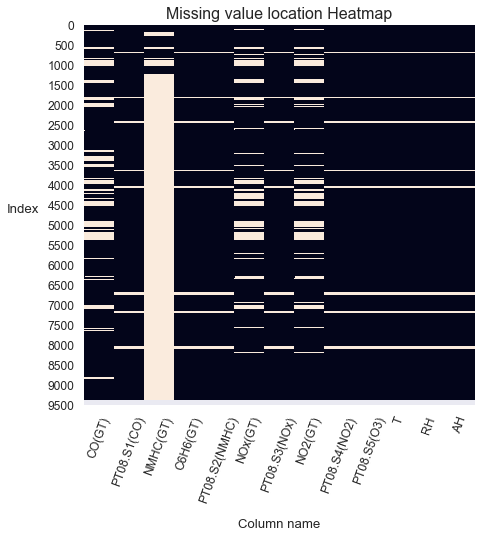

In [93]:
### The location of missing value: Heatmap

plt.figure(figsize=(7, 7))
fig = sns.heatmap(airdata.iloc[ : , 2:15 ].applymap(lambda x: x == -200), cbar=False,  yticklabels = np.arange(0, 10000, 500))
fig.yaxis.set_ticks(np.arange(0, 10000, 500))
fig.set_xticklabels(fig.get_xticklabels(), rotation = 70)
fig.set_title('Missing value location Heatmap', fontsize = 16)
plt.xlabel("Column name", labelpad=14)
plt.ylabel("Index", rotation=0, labelpad=24)
sns.set(font_scale=1.1)
plt.show()


#### Concl. The sensor's 366 missing value are in the same location.

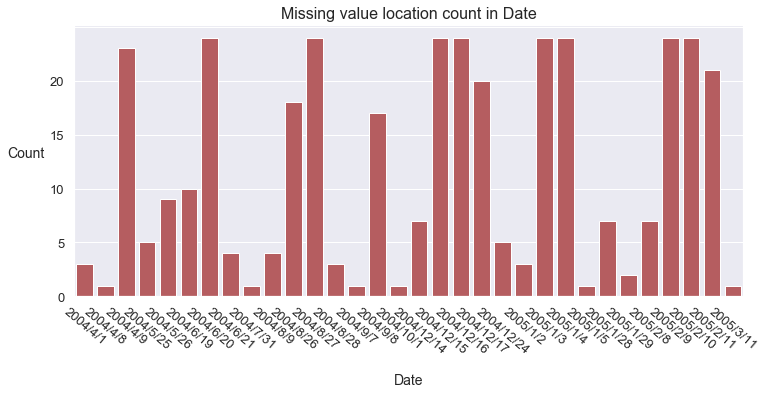

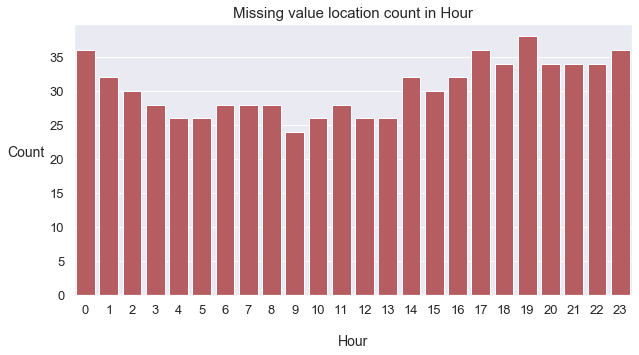

In [94]:
### Missing at random or not

## Relationship with day
air_missing = airdata[airdata['PT08.S4(NO2)'] == -200]
air_temp = pd.DataFrame(air_missing['str_date'])
plt.figure(figsize=(12,5))
fig = sns.countplot(x='str_date', data=air_temp, palette=["C3"])
fig.set_title('Missing value location count in Date', fontsize = 16)
fig.set_xticklabels(list(air_missing['str_date'].drop_duplicates()), rotation=320, fontsize = 13)
fig.set_yticklabels(np.arange(0, 25, 5), fontsize = 13)
plt.xlabel("Date", labelpad=17, fontsize = 14)
plt.ylabel("Count", rotation=0, labelpad=24, fontsize = 14)
plt.show()

#### concl. 資料中全天都是missing value的有8天


## Relationship with hour
temp = airdata[airdata.iloc[ : , 3 ] == -200]
temp = pd.DataFrame(temp.iloc[:, 19])
plt.figure(figsize=(10,5))
fig = sns.countplot(x="hour", data=temp, palette=["C3"])
fig.set_title('Missing value location count in Hour', fontsize = 15)
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 13)
fig.set_yticklabels(np.arange(0, 40, 5), fontsize = 13)
plt.xlabel("Hour", labelpad=17, fontsize = 14)
plt.ylabel("Count", rotation=0, labelpad=24, fontsize = 14)
plt.show()

#### concl. there is no hour specific on missing value, we can assume missing at random





#### Concl. We can assume missing at random.

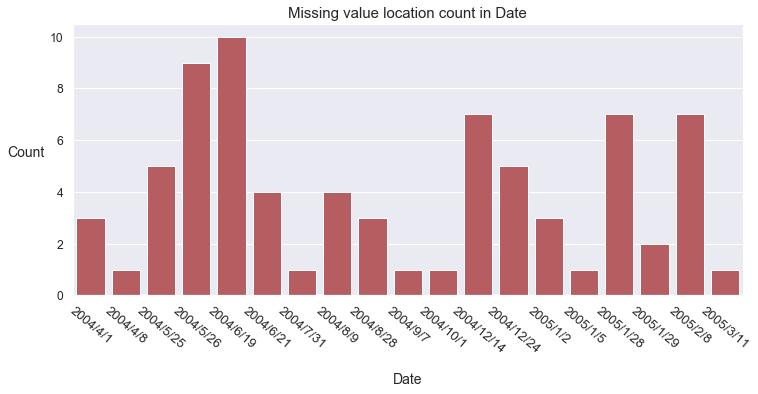

In [95]:
#### Engineering on missing value


## Delete missing value more than 12 within a day
temp = airdata[airdata['PT08.S4(NO2)'] == -200]
temp = temp['Date'].value_counts()
temp = (temp[temp > 12]).index
airdata = airdata[~airdata['Date'].isin(temp)]
# airdata[airdata['PT08.S4(NO2)'] == -200]['Date'].value_counts()    # can directly check the remaining missing amount
air_temp = airdata[airdata['PT08.S4(NO2)'] == -200]

plt.figure(figsize=(12,5))
fig = sns.countplot(x="Date", data=air_temp, palette=["C3"])
fig.set_title('Missing value location count in Date', fontsize = 15)
fig.set_xticklabels(list(air_temp['str_date'].drop_duplicates()), rotation=320, fontsize = 13)
plt.xlabel("Date", labelpad=17, fontsize = 14)
plt.ylabel("Count", rotation=0, labelpad=24, fontsize = 14)
plt.show()




#### Concl. We have eliminate the day which the amount of missing is greater than 12.

In [97]:
#### Pollution status in same hour regardless of day 

## NO2
for x in list(range(24)):
    temp = airdata[airdata['hour'] == x]
    temp1 = temp['PT08.S4(NO2)']
    time = temp['str_date']
    
    trace = go.Scatter(x = time, 
                       y = temp1, 
                       name= 'PT08.S4(NO2)')
    
    layout = go.Layout(dict(title = "NO2 amount at"+' '+ str(x)+ ':00 '+ "regardless of days",                            
                            width=800,
                            height=350,
                            margin=go.layout.Margin(
                                l=80,
                                r=80,
                                b=90,
                                t=70,),
                            xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =30.0, tickangle=30),
                            yaxis = dict(title = 'Concentration', range = [500, 3000]),
                            ),legend=dict(
        orientation="v"))
    dataPanda = []
    dataPanda.append(trace)
    py.iplot(dict(data=dataPanda, layout=layout))

## O3
for x in list(range(24)):
    temp = airdata[airdata['hour'] == x]
    temp1 = temp['PT08.S5(O3)']
    time = temp['str_date']

    trace = go.Scatter(x = time, 
                       y = temp1, 
                       name= 'PT08.S5(O3)')
    
    layout = go.Layout(dict(title = "O3 amount at"+' '+ str(x)+ ':00 '+ "regardless of days",
                            width=800,
                            height=350,
                            margin=go.layout.Margin(
                                l=80,
                                r=80,
                                b=90,
                                t=70,),
                            xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =30.0, tickangle=30),
                            yaxis = dict(title = 'Concentration', range = [0, 2500]),
                            ),legend=dict(
        orientation="v"))    
    dataPanda = []
    dataPanda.append(trace)
    py.iplot(dict(data=dataPanda, layout=layout))

NameError: name 'kk' is not defined

#### Concl. The concentration of pollutant NO2 and O3 might be highly related to time, similar to the period of human activity. (the dramatic drop is due to the missing value -200)

In [98]:
#### Impute missing value 

## NO2 and O3
index = list((airdata[airdata['PT08.S4(NO2)'] == -200]).index)

for x in list(range(len(index))):
    airdata['PT08.S4(NO2)'][index[x]] = mean((airdata['PT08.S4(NO2)'][[index[x]-48, index[x]-24, index[x]+24, index[x]+48]]).to_list())
    airdata['PT08.S5(O3)'][index[x]]  = mean((airdata['PT08.S5(O3)'][[index[x]-48, index[x]-24, index[x]+24, index[x]+48]]).to_list())

airdata[airdata['PT08.S4(NO2)'] == -200]



/Users/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning:


Passing list-li

Empty DataFrame
Columns: [Date, Time, CO(GT), PT08.S1(CO), NMHC(GT), C6H6(GT), PT08.S2(NMHC), NOx(GT), PT08.S3(NOx), NO2(GT), PT08.S4(NO2), PT08.S5(O3), T, RH, AH, Datetime, year, month, day, hour, str_date]
Index: []

#### Concl. We impute the missing value with the mean of the same hour in 5 sequential day.

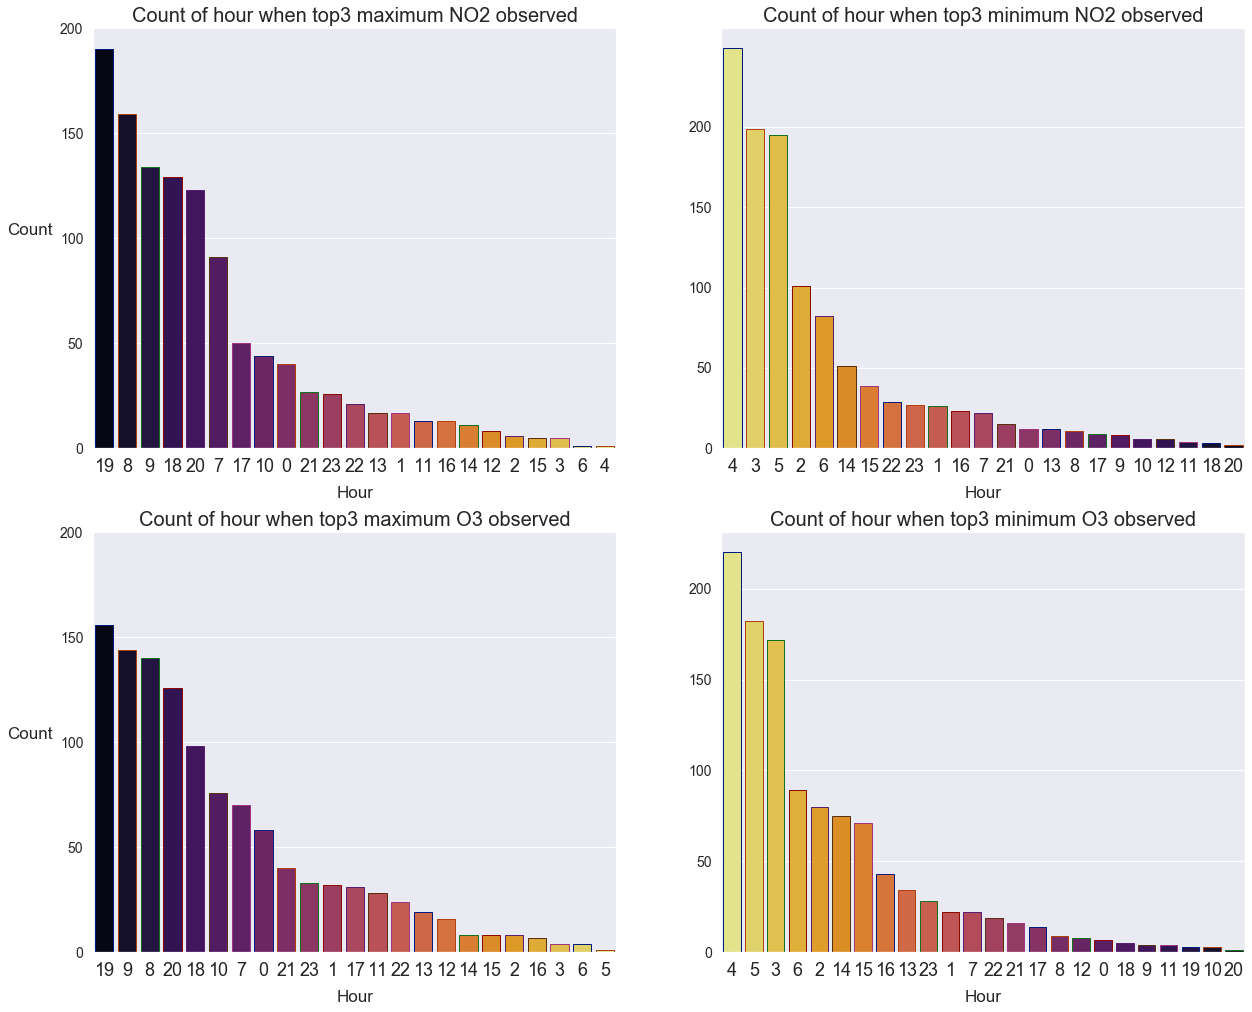

In [99]:
#### NO2 and O3 hour count

air_temp = airdata.iloc[6:9342, [0,10,11,19] ]  ## eliminate incomplete day

datastorage0 = pd.DataFrame()
datastorage1 = pd.DataFrame()
datastorage2 = pd.DataFrame()
datastorage3 = pd.DataFrame()

for x in list(range(1, 390)):
    t, r = 24*x, 24*(x-1)
    temp = air_temp.iloc[r:t , : ]
    
    temp0 = temp.sort_values((['Date', 'PT08.S4(NO2)']),axis = 0, ascending = [True, False]).head(3)
    datastorage0 = pd.concat([datastorage0,temp0['hour']],axis=0)
    temp1 = temp.sort_values((['Date', 'PT08.S5(O3)']),axis = 0, ascending = [True, False]).head(3)
    datastorage1 = pd.concat([datastorage1,temp1['hour']],axis=0)
    temp2 = temp.sort_values((['Date', 'PT08.S4(NO2)']),axis = 0, ascending = [True, False]).tail(3)
    datastorage2 = pd.concat([datastorage2,temp2['hour']],axis=0)
    temp3 = temp.sort_values((['Date', 'PT08.S5(O3)']),axis = 0, ascending = [True, False]).tail(3)
    datastorage3 = pd.concat([datastorage3,temp3['hour']],axis=0)
    
datastorage0 = datastorage0.iloc[:,0].astype(int)
datastorage1 = datastorage1.iloc[:,0].astype(int)
datastorage2 = datastorage2.iloc[:,0].astype(int)
datastorage3 = datastorage3.iloc[:,0].astype(int)



plt.figure(figsize=(20, 17))

plt.subplots_adjust(left=0.1)

plt.subplot(221)
fig = sns.countplot(x=datastorage0, order = datastorage0.value_counts().sort_values(ascending = False).index, palette='inferno',edgecolor=sns.color_palette('dark',7))
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 18)
plt.yticks(np.arange(0, 250, 50), fontsize = 14)
plt.xlabel('Hour', fontsize = 17,  labelpad = 10)
plt.ylabel('Count', fontsize = 17, rotation = 0, labelpad = 30)
plt.title('Count of hour when top3 maximum NO2 observed', fontsize = 20)

plt.subplot(223)
fig = sns.countplot(x=datastorage1, order = datastorage1.value_counts().sort_values(ascending = False).index, palette='inferno',edgecolor=sns.color_palette('dark',7))
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 18)
plt.yticks(np.arange(0, 250, 50), fontsize = 14)
plt.xlabel('Hour', fontsize = 17,  labelpad = 10)
plt.ylabel('Count', fontsize = 17, rotation = 0, labelpad = 30)
plt.title('Count of hour when top3 maximum O3 observed', fontsize = 20)

plt.subplot(222)
fig = sns.countplot(x=datastorage2, order = datastorage2.value_counts().sort_values(ascending = False).index, palette='inferno_r', edgecolor=sns.color_palette('dark',7))
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 18)
plt.yticks(np.arange(0, 250, 50), fontsize = 14)
plt.xlabel('Hour', fontsize = 17,  labelpad = 10)
plt.ylabel('')
plt.title('Count of hour when top3 minimum NO2 observed', fontsize = 20)

plt.subplot(224)
fig = sns.countplot(x=datastorage3, order = datastorage3.value_counts().sort_values(ascending = False).index, palette='inferno_r',edgecolor=sns.color_palette('dark',7))
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 18)
plt.yticks(np.arange(0, 250, 50), fontsize = 14)
plt.xlabel('Hour', fontsize = 17,  labelpad = 10)
plt.ylabel('')
plt.title('Count of hour when top3 minimum O3 observed', fontsize = 20)
plt.show()




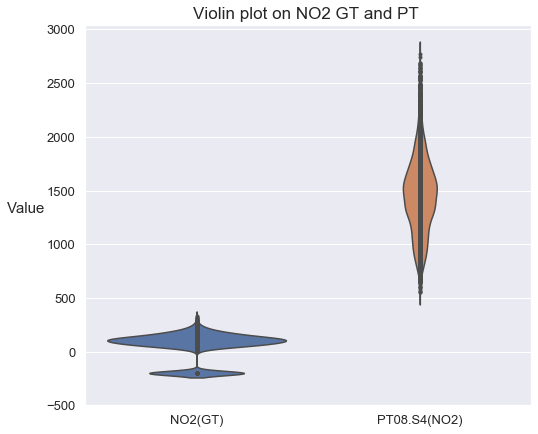

([<matplotlib.axis.YTick at 0x1a1cb073c8>,
 <a list of 5 Text yticklabel objects>)

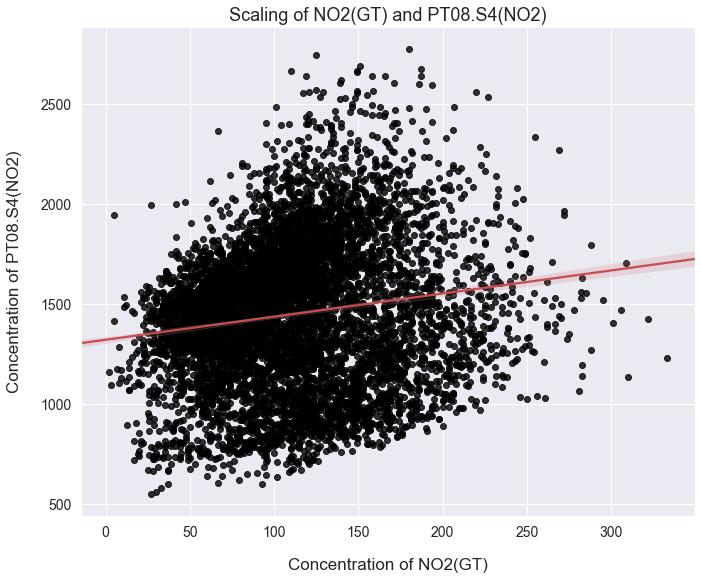

In [100]:
#### Scaling of PT and GT

## Violin plot
plt.figure(figsize=(8, 7))
air_temp = airdata[['NO2(GT)','PT08.S4(NO2)']]
sns.violinplot(data=air_temp, inner="points")
plt.title('Violin plot on NO2 GT and PT ', fontsize = 17)
plt.ylabel('Value', fontsize = 15, labelpad = 20, rotation = 0)
plt.yticks(np.arange(-500, 3100, 500), fontsize = 13)
plt.xticks(fontsize = 13)
plt.show()

## Scatter plot
air_temp = air_temp[air_temp['NO2(GT)'] > -200]
plt.figure(figsize=(11, 9))
sns.regplot(x=air_temp['NO2(GT)'], 
            y = air_temp['PT08.S4(NO2)'], 
            scatter_kws={'color': sns.xkcd_rgb['black']}, 
            line_kws={"color":"r"})
plt.xlabel('Concentration of NO2(GT)', fontsize = 17, labelpad = 18)
plt.ylabel('Concentration of PT08.S4(NO2)', fontsize = 17, labelpad = 18)
plt.title('Scaling of NO2(GT) and PT08.S4(NO2)', fontsize = 18)
plt.xticks(np.arange(0, 350, 50), fontsize = 14)
plt.yticks(np.arange(500, 3000, 500), fontsize = 14)



[[0.13247844]] [-77.39224514]


/Users/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0    2004-03-10  18.00.00     2.6       1360.0     150.0      11.9   
1    2004-03-10  19.00.00     2.0       1292.0     112.0       9.4   
2    2004-03-10  20.00.00     2.2       1402.0      88.0       9.0   
3    2004-03-10  21.00.00     2.2       1376.0      80.0       9.2   
4    2004-03-10  22.00.00     1.6       1272.0      51.0       6.5   
5    2004-03-10  23.00.00     1.2       1197.0      38.0       4.7   
6    2004-03-11  00.00.00     1.2       1185.0      31.0       3.6   
7    2004-03-11  01.00.00     1.0       1136.0      31.0       3.3   
8    2004-03-11  02.00.00     0.9       1094.0      24.0       2.3   
9    2004-03-11  03.00.00     0.6       1010.0      19.0       1.7   
10   2004-03-11  04.00.00  -200.0       1011.0      14.0       1.3   
11   2004-03-11  05.00.00     0.7       1066.0       8.0       1.1   
12   2004-03-11  06.00.00     0.7       1052.0      16.0       1.6   
13   2004-03-11  07.00.00     1.1       1144.0      29.0       3.2   
14   2004-03-11  08.00.00     2.0       1333.0      64.0       8.0   
15   2004-03-11  09.00.00     2.2       1351.0      87.0       9.5   
16   2004-03-11  10.00.00     1.7       1233.0      77.0       6.3   
17   2004-03-11  11.00.00     1.5       1179.0      43.0       5.0   
18   2004-03-11  12.00.00     1.6       1236.0      61.0       5.2   
19   2004-03-11  13.00.00     1.9       1286.0      63.0       7.3   
20   2004-03-11  14.00.00     2.9       1371.0     164.0      11.5   
21   2004-03-11  15.00.00     2.2       1310.0      79.0       8.8   
22   2004-03-11  16.00.00     2.2       1292.0      95.0       8.3   
23   2004-03-11  17.00.00     2.9       1383.0     150.0      11.2   
24   2004-03-11  18.00.00     4.8       1581.0     307.0      20.8   
25   2004-03-11  19.00.00     6.9       1776.0     461.0      27.4   
26   2004-03-11  20.00.00     6.1       1640.0     401.0      24.0   
27   2004-03-11  21.00.00     3.9       1313.0     197.0      12.8   
28   2004-03-11  22.00.00     1.5        965.0      61.0       4.7   
29   2004-03-11  23.00.00     1.0        913.0      26.0       2.6   
30   2004-03-12  00.00.00     1.7       1080.0      55.0       5.9   
31   2004-03-12  01.00.00     1.9       1044.0      53.0       6.4   
32   2004-03-12  02.00.00     1.4        988.0      40.0       4.1   
33   2004-03-12  03.00.00     0.8        889.0      21.0       1.9   
34   2004-03-12  04.00.00  -200.0        831.0      10.0       1.1   
35   2004-03-12  05.00.00     0.6        847.0       7.0       1.0   
36   2004-03-12  06.00.00     0.8        927.0      17.0       1.8   
37   2004-03-12  07.00.00     1.4       1091.0      33.0       4.4   
38   2004-03-12  08.00.00     4.4       1587.0     202.0      17.9   
39   2004-03-12  09.00.00  -200.0       1545.0    -200.0      22.1   
40   2004-03-12  10.00.00     3.1       1350.0     208.0      14.0   
41   2004-03-12  11.00.00     2.7       1263.0     166.0      11.6   
42   2004-03-12  12.00.00     2.1       1206.0     114.0      10.2   
43   2004-03-12  13.00.00     2.5       1252.0     140.0      11.0   
44   2004-03-12  14.00.00     2.7       1287.0     169.0      12.8   
45   2004-03-12  15.00.00     2.9       1353.0     185.0      14.2   
46   2004-03-12  16.00.00     2.8       1309.0     165.0      12.7   
47   2004-03-12  17.00.00     2.4       1274.0     133.0      11.7   
48   2004-03-12  18.00.00     3.9       1510.0     233.0      19.3   
49   2004-03-12  19.00.00     3.7       1525.0     242.0      18.2   
50   2004-03-12  20.00.00     6.6       1843.0     488.0      32.6   
51   2004-03-12  21.00.00     4.4       1598.0     333.0      20.1   
52   2004-03-12  22.00.00     3.5       1484.0     215.0      14.3   
53   2004-03-12  23.00.00     5.4       1677.0     367.0      21.8   
54   2004-03-13  00.00.00     2.7       1280.0     122.0       9.6   
55   2004-03-13  01.00.00     1.9       1196.0      67.0       7.4   
56   2004-03-13  02.0

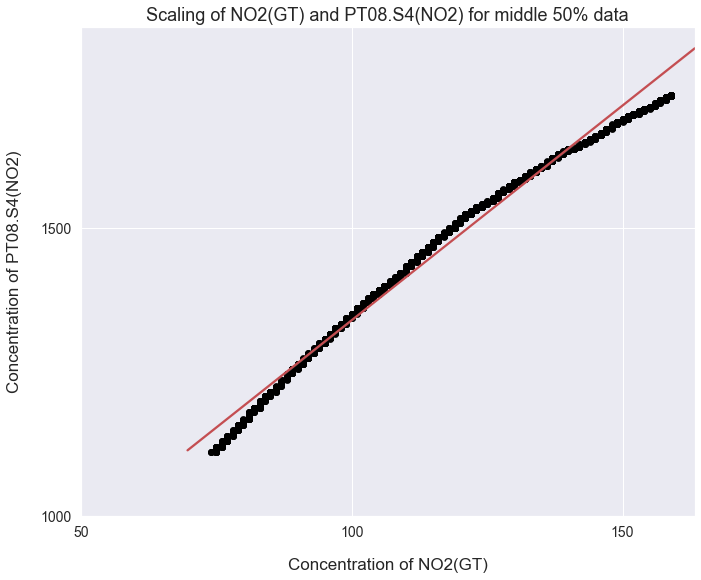

In [130]:
#### Scaling PT and GT

## Middle 50% (25%~75%)
## instead of using percentage, we can only use exact amount here, because percentage won't create equal length
air_temp = airdata[airdata['NO2(GT)'] > -200]
air_GT = air_temp['NO2(GT)']
air_PT = air_temp['PT08.S4(NO2)']

def middle_50(series):
    mean = series.mean()
    
    high = series[series > mean]
    high = high.sort_values(ascending = False).tail(2250)
    low = series[series <= mean]
    low = low.sort_values(ascending = False).head(2250)
    
    out = pd.concat([high, low], ignore_index=True)
    return out

arranged = pd.concat([middle_50(air_GT), middle_50(air_PT)], axis=1)

## Visualization
plt.figure(figsize=(11, 9))
sns.regplot(x=arranged['NO2(GT)'], y = arranged['PT08.S4(NO2)'], scatter_kws={'color': sns.xkcd_rgb['black']}, line_kws={"color":"r"})
plt.xlabel('Concentration of NO2(GT)', fontsize = 17, labelpad = 18)
plt.ylabel('Concentration of PT08.S4(NO2)', fontsize = 17, labelpad = 18)
plt.title('Scaling of NO2(GT) and PT08.S4(NO2) for middle 50% data', fontsize = 18)
plt.xticks(np.arange(50, 200, 50), fontsize = 14)
plt.yticks(np.arange(1000, 2000, 500), fontsize = 14)

## Transform NO2
regressor = LinearRegression()  
regressor.fit(np.array(arranged['PT08.S4(NO2)']).reshape(-1, 1), np.array(arranged['NO2(GT)']).reshape(-1, 1))
print(regressor.coef_, regressor.intercept_)

airdata['adj_NO2 (μg/m3)'] = (airdata['PT08.S4(NO2)'].apply(lambda x: x * 0.13247844 - 77.39224514))

### we suppose to add intercept, because the road based is supposed to be higher than station data
### but we have no any data to do this





In [7]:
#### Calculate the Increase in mortality risk 

## we take base line 47 microg/m^3, which comes from the average of NO2 the mean in 10 city
## for NO2, values consistently exceeded 40 μg/m3 in six cities

## Calculation
temp = airdata.copy()
temp['select'] = np.logical_and(airdata['month'] >3, airdata['month'] < 10) *1

warm_season, cold_season = temp[temp['select'] == 1], temp[temp['select'] == 0]
warm_season, cold_season = warm_season['adj_NO2 (μg/m3)'], cold_season['adj_NO2 (μg/m3)']
warm_season, cold_season = (warm_season-47) * 4.64/10, (cold_season-47) * 1.18/10
airdata['Increase in mortality risk(%)']  = pd.concat([cold_season, warm_season], axis = 0, ignore_index=False).sort_index()

## Visualization
trace = go.Scatter(x = airdata['str_date'], y = airdata['Increase in mortality risk(%)'],marker=dict(color='#851e52'))
layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =30.0, tickangle=315),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (temp.min(), temp.max()))
                        
                        ),legend=dict(
    orientation="v"))
datastore = []
datastore.append(trace)

py.iplot(dict(data=datastore, layout=layout))


##### arima get from here


In [9]:
## Split train and test
def train_test_split(input_df):
    y = input_df['Increase in mortality risk(%)']
    x = input_df.loc[:, input_df.columns != 'Increase in mortality risk(%)']
    train_size = int(len(x) * 0.8)
    x_train = x[0:train_size]
    y_train = x[train_size:len(x)]
    x_test, y_test = y[0:train_size], y[train_size:len(x)]
    return x_train, y_train, x_test, y_test

## Visualization of Train and Test
x_train, y_train, x_test, y_test = train_test_split(airdata)
time = x_train["year"].map(str)+ '/' + x_train["month"].map(str) + '/'+  x_train["day"].map(str)
time1 = y_train["year"].map(str)+ '/' + y_train["month"].map(str) + '/'+  y_train["day"].map(str)


trace1 = go.Scatter(x = time,
                    y = x_test,
                    name = 'Train',
                    marker=dict(color='rgb(22, 96, 167)'))
trace2 = go.Scatter(x = time1,
                    y = y_test,
                    name = 'Test',
                    marker=dict(color='#851e52'))

layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =30.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 160)
                        ),legend=dict(
    orientation="v")))

datastore = []
datastore.append(trace1)
datastore.append(trace2)

py.iplot(dict(data=datastore, layout=layout))

In [21]:
#### Preparing for prediction set

## the prediction set without lagged
future = pd.DataFrame(pd.date_range('2005-04-04', periods=150, freq='H'))
future = future.iloc[14:134,:].reset_index(drop=True)
future.columns = ['Date']
future['Date'] = pd.to_datetime(future['Date'], format='%d/%m/%Y %H') 
future['year'] = future['Date'].dt.year
future['month'] = future['Date'].dt.month
future['day'] = future['Date'].dt.day
future['hour'] = future['Date'].dt.hour
future['seasonality'] = 1
future = future.drop('Date', axis = 1)
temp = air[['Increase in mortality risk(%)', 'month', 'year', 'day', 'hour']].tail(100)
future_wo_lag = pd.concat([temp, future]).reset_index(drop = True)
future = future_wo_lag

NameError: name 'air' is not defined

In [22]:

#### now you are here ####



#### Collecting data for model and missing while lagged

air = airdata[['year', 'month', 'day', 'hour', 'Increase in mortality risk(%)']]

## seasonality  ## rolling
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1
lag = pd.DataFrame()
lag['Lag_mean_6'] = air['Increase in mortality risk(%)'].rolling(7).mean()
lag['Lag_sd_6'] = air['Increase in mortality risk(%)'].rolling(7).std()
lag['Lag_mean_12'] = air['Increase in mortality risk(%)'].rolling(13).mean()
lag['Lag_sd_12'] = air['Increase in mortality risk(%)'].rolling(13).std()
lag['Lag_mean_18'] = air['Increase in mortality risk(%)'].rolling(19).mean()
lag['Lag_sd_18'] = air['Increase in mortality risk(%)'].rolling(19).std()
lag['Lag_mean_24'] = air['Increase in mortality risk(%)'].rolling(25).mean()
lag['Lag_sd_24'] = air['Increase in mortality risk(%)'].rolling(25).std()

blank = pd.DataFrame(np.full([1,8,], np.nan), columns=lag.columns.tolist())
lag = blank.append(lag, ignore_index=True)
air = pd.concat([air, lag], axis = 1, ignore_index=False)

air['same_hour_1_day_shift'] = air['Increase in mortality risk(%)'].shift(24)   ## lag 24
air['same_hour_2_day_shift'] = air['Increase in mortality risk(%)'].shift(48)  ## lag 48

air = air.dropna(axis = 0)

x_train, y_train, x_test, y_test = train_test_split(air)


rf = RandomForestRegressor(n_estimators= 59, 
                           min_samples_split= 10, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 310,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
rf.score(y_train, y_test)


feature_imp = pd.Series(rf.feature_importances_,index=x_train.columns).sort_values(ascending=False)
pd.DataFrame(feature_imp, columns = ['feature_importance'])


/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



NameError: name 'train_test_split' is not defined

In [23]:
## create lag
def roll_and_bind(df):
    df['lag_1'] = df['your target'].shift(1)   ## lag 1
    df['lag_2'] = df['your target'].shift(2)  ## lag 2
    df['lag_3'] = df['your target'].shift(3)  ## lag 2
    return df

## 這個loop會把你預測的值放回那個row，做一次lag，再預測下一個，再放回去，再做lag
for x in list(range(0,120)):  ###總共要預測的row數目
    temp = roll_and_bind(future)   ## future是你的預測集，包含所有時間資料，但沒有lag  ##我把它lag後存到temp
    train = (temp[temp.index == (100+x)]).drop(columns = ['your target']) ##把temp裡面的target丟掉
    predictions = rf.predict(train)  ## 做預測
    future.iloc[100+x,0] = predictions ## 預測完之後放回去原來的future

KeyError: 'your target'

In [24]:
#### Predict future 5 days


def roll_and_bind(df):
    temp = pd.DataFrame()
    temp['Lag_mean_6'] = df['Increase in mortality risk(%)'].rolling(6).mean()
    temp['Lag_sd_6'] = df['Increase in mortality risk(%)'].rolling(6).std()
    temp['Lag_mean_12'] = df['Increase in mortality risk(%)'].rolling(12).mean()
    temp['Lag_sd_12'] = df['Increase in mortality risk(%)'].rolling(12).std()
    temp['Lag_mean_18'] = df['Increase in mortality risk(%)'].rolling(18).mean()
    temp['Lag_sd_18'] = df['Increase in mortality risk(%)'].rolling(18).std()
    temp['Lag_mean_24'] = df['Increase in mortality risk(%)'].rolling(24).mean()
    temp['Lag_sd_24'] = df['Increase in mortality risk(%)'].rolling(24).std()
    blank = pd.DataFrame(np.full([1,8,], np.nan), columns=temp.columns.tolist())   ## change full when eliminate
    temp = blank.append(temp, ignore_index=True)
    df = pd.concat([df, temp], axis = 1, ignore_index=False)
    df['same_hour_1_day_shift'] = df['Increase in mortality risk(%)'].shift(24)   ## lag 24
    df['same_hour_2_day_shift'] = df['Increase in mortality risk(%)'].shift(48)  ## lag 48
    return df


for x in list(range(0,120)):
    temp = roll_and_bind(future)
    train = (temp[temp.index == (100+x)]).drop(columns = ['Increase in mortality risk(%)'])
    predictions = rf.predict(train)
    future.iloc[100+x,0] = predictions



KeyError: 'Increase in mortality risk(%)'

In [168]:
#### Visualization of our prediction

time = future["year"].astype(int).map(str)+ '/' + future["month"].astype(int).map(str) + '/'+  future["day"].astype(int).map(str) +' ' + future['hour'].astype(int).map(str) + ":00"
temp1 = future['Increase in mortality risk(%)']

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Lag 1',
                    marker=dict(color='rgb(22, 96, 167)'))


layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace1)

py.iplot(dict(data=datastore, layout=layout))

In [25]:
#### Collecting data for model and missing while lagged

air = airdata[['year', 'month', 'day', 'hour', 'Increase in mortality risk(%)']]

## seasonality  ## rolling
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1
lag = pd.DataFrame()
air['same_hour_1_day_shift'] = air['Increase in mortality risk(%)'].shift(24)   ## lag 24
air['same_hour_2_day_shift'] = air['Increase in mortality risk(%)'].shift(48)  ## lag 48
air = air.dropna(axis = 0)

x_train, y_train, x_test, y_test = train_test_split(air)


rf = RandomForestRegressor(n_estimators= 59, 
                           min_samples_split= 10, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 310,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
rf.score(y_train, y_test)


feature_imp = pd.Series(rf.feature_importances_,index=x_train.columns).sort_values(ascending=False)
pd.DataFrame(feature_imp, columns = ['feature_importance'])




#### Predict future 5 days

## the prediction set
future = pd.DataFrame(pd.date_range('2005-04-04', periods=150, freq='H'))
future = future.iloc[14:134,:].reset_index(drop=True)
future.columns = ['Date']
future['Date'] = pd.to_datetime(future['Date'], format='%d/%m/%Y %H') 
future['year'] = future['Date'].dt.year
future['month'] = future['Date'].dt.month
future['day'] = future['Date'].dt.day
future['hour'] = future['Date'].dt.hour
future['seasonality'] = 1
future = future.drop('Date', axis = 1)
temp = air[['Increase in mortality risk(%)', 'month', 'year', 'day', 'hour']].tail(100)
future_wo_lag = pd.concat([temp, future]).reset_index(drop = True)
future = future_wo_lag

def roll_and_bind(df):
    temp = pd.DataFrame()
    df['same_hour_1_day_shift'] = df['Increase in mortality risk(%)'].shift(24)   ## lag 24
    df['same_hour_2_day_shift'] = df['Increase in mortality risk(%)'].shift(48)  ## lag 48
    return df


for x in list(range(0,120)):
    temp = roll_and_bind(future)
    train = (temp[temp.index == (100+x)]).drop(columns = ['Increase in mortality risk(%)'])
    predictions = rf.predict(train)
    future.iloc[100+x,0] = predictions

future

#### Visualization of our prediction

time = future["year"].map(str)+ '/' + future_wo_lag["month"].map(str) + '/'+  future_wo_lag["day"].map(str) +' ' + future_wo_lag['hour'].map(str) + ":00"
temp1 = future['Increase in mortality risk(%)']

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Lag 1',
                    marker=dict(color='rgb(22, 96, 167)'))


layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace1)

py.iplot(dict(data=datastore, layout=layout))






/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

NameError: name 'train_test_split' is not defined

In [26]:
#### Collecting data for model and missing while lagged

air = airdata[['year', 'month', 'day', 'hour', 'Increase in mortality risk(%)']]

def train_test_split(input_df):
    y = input_df['Increase in mortality risk(%)']
    x = input_df.loc[:, input_df.columns != 'Increase in mortality risk(%)']
    train_size = int(len(x) * 0.8)
    x_train = x[0:train_size]
    y_train = x[train_size:len(x)]
    x_test, y_test = y[0:train_size], y[train_size:len(x)]
    return x_train, y_train, x_test, y_test

## seasonality  ## rolling
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1
lag = pd.DataFrame()
lag['Lag_sd_6'] = air['Increase in mortality risk(%)'].rolling(2).std()
lag['Lag_mean_6'] = air['Increase in mortality risk(%)'].rolling(24).mean()
lag['Lag_max_6'] = air['Increase in mortality risk(%)'].rolling(24).max()

blank = pd.DataFrame(np.full([1,3,], np.nan), columns=lag.columns.tolist())
lag = blank.append(lag, ignore_index=True)
air = pd.concat([air, lag], axis = 1, ignore_index=False)

air['same_hour_1_day_shift'] = air['Increase in mortality risk(%)'].shift(24)   ## lag 24
air['same_hour_2_day_shift'] = air['Increase in mortality risk(%)'].shift(48)  ## lag 48

air = air.dropna(axis = 0)

x_train, y_train, x_test, y_test = train_test_split(air)


rf = RandomForestRegressor(n_estimators= 59, 
                           min_samples_split= 10, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 310,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
rf.score(y_train, y_test)


feature_imp = pd.Series(rf.feature_importances_,index=x_train.columns).sort_values(ascending=False)
feature_imp


#### Predict future 5 days

## the prediction set
future = pd.DataFrame(pd.date_range('2005-04-04', periods=150, freq='H'))
future = future.iloc[14:134,:].reset_index(drop=True)
future.columns = ['Date']
future['Date'] = pd.to_datetime(future['Date'], format='%d/%m/%Y %H') 
future['year'] = future['Date'].dt.year
future['month'] = future['Date'].dt.month
future['day'] = future['Date'].dt.day
future['hour'] = future['Date'].dt.hour
future['seasonality'] = 1
future = future.drop('Date', axis = 1)
temp = air[['Increase in mortality risk(%)', 'month', 'year', 'day', 'hour']].tail(100)
future_wo_lag = pd.concat([temp, future]).reset_index(drop = True)
future = future_wo_lag

def roll_and_bind(df):
    temp = pd.DataFrame()
    temp['Lag_sd_6'] = df['Increase in mortality risk(%)'].rolling(2).std()
    temp['Lag_mean_6'] = df['Increase in mortality risk(%)'].rolling(24).mean()
    temp['Lag_max_6'] = df['Increase in mortality risk(%)'].rolling(24).max()

    blank = pd.DataFrame(np.full([1,3,], np.nan), columns=temp.columns.tolist())   ## change full when eliminate
    temp = blank.append(temp, ignore_index=True)
    df = pd.concat([df, temp], axis = 1, ignore_index=False)
    df['same_hour_1_day_shift'] = df['Increase in mortality risk(%)'].shift(24)   ## lag 24
    df['same_hour_2_day_shift'] = df['Increase in mortality risk(%)'].shift(48)  ## lag 48
    return df


for x in list(range(0,120)):
    temp = roll_and_bind(future)
    train = (temp[temp.index == (100+x)]).drop(columns = ['Increase in mortality risk(%)'])
    predictions = rf.predict(train)
    future.iloc[100+x,0] = predictions

future

#### Visualization of our prediction

time = future["year"].map(str)+ '/' + future_wo_lag["month"].map(str) + '/'+  future_wo_lag["day"].map(str) +' ' + future_wo_lag['hour'].map(str) + ":00"
temp1 = future['Increase in mortality risk(%)']

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Lag 1',
                    marker=dict(color='rgb(22, 96, 167)'))


layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace1)

py.iplot(dict(data=datastore, layout=layout))





/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [125]:
## lag
for y in range(0,4):
    for x in range(1,25):  ### this is the day shift
        air.loc[:,'Mortality_risk_lag_'+str(x)] = air['Increase in mortality risk(%)'].shift(x)
        air.loc[:,'Hour_lag_'+str(y)] = air['Increase in mortality risk(%)'].shift(24*y)

air = air.drop(columns=['Hour_lag_0'])
temp = air.iloc[:,7:16]

temp = air.iloc[:,6:33]
temp_x =  air.iloc[:, 0:6]
temp_6 = (temp.iloc[:,0:6]).mean(axis=1)
temp_12 = (temp.iloc[:,0:12]).mean(axis=1)
temp_18 = temp.iloc[:,0:18].mean(axis=1)
temp_24 = temp.iloc[:,0:24].mean(axis=1)
temp_x['mean6'] = temp_6
temp_x['mean12'] = temp_12
temp_x['mean18'] = temp_18
temp_x['mean24'] = temp_24
temp_x = (temp_x.drop(temp_x.index[0:24])).reset_index(drop=True)

def train_test_split(input_df):
    y = input_df['Increase in mortality risk(%)']
    x = input_df.loc[:, input_df.columns != 'Increase in mortality risk(%)']
    train_size = int(len(x) * 0.8)
    x_train = x[0:train_size]
    y_train = x[train_size:len(x)]
    x_test, y_test = y[0:train_size], y[train_size:len(x)]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = train_test_split(temp_x)


/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

In [126]:
#### Predict future 5 days

## the prediction set
air = airdata[['year', 'month', 'day', 'hour','Increase in mortality risk(%)']]
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1
future = pd.DataFrame(pd.date_range('2005-04-04', periods=150, freq='H'))
future = future.iloc[14:134,:].reset_index(drop=True)
future.columns = ['Date']
future['Date'] = pd.to_datetime(future['Date'], format='%d/%m/%Y %H') 
future['year'] = future['Date'].dt.year
future['month'] = future['Date'].dt.month
future['day'] = future['Date'].dt.day
future['hour'] = future['Date'].dt.hour
future['seasonality'] = 1
future = future.drop('Date', axis = 1)
temp = air[['Increase in mortality risk(%)', 'month', 'year', 'day', 'hour']].tail(28)
future_wo_lag = pd.concat([temp, future]).reset_index(drop = True)
future = future_wo_lag


x_train, y_train, x_test, y_test = train_test_split(temp_x)
rf = RandomForestRegressor(n_estimators= 93, 
                           min_samples_split= 3, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 30,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
errors = abs(predictions - y_test)
for z in range(0,120):
    for x in range(1,25):  ### this is the shift within day
        future.loc[:,'Mortality_risk_lag_'+str(x)] = future['Increase in mortality risk(%)'].shift(x)
    temp = future
    temp_main = temp.iloc[:, 0:6]
    temp_6 = (temp.iloc[:,6:12]).mean(axis=1)
    temp_12 = (temp.iloc[:,12:18]).mean(axis=1)
    temp_18 = (temp.iloc[:,18:24]).mean(axis=1)
    temp_24 = (temp.iloc[:,24:30]).mean(axis=1)
    temp_main['mean6'] = temp_6
    temp_main['mean12'] = temp_12
    temp_main['mean18'] = temp_18
    temp_main['mean24'] = temp_24

    train = (temp_main[temp_main.index == (28+z)]).drop(columns = ['Increase in mortality risk(%)'])
    print(train)
    predictions = rf.predict(train)
    future_wo_lag.iloc[28+z,0] = predictions

    
#### Visualization of our prediction

time = future_wo_lag["year"].map(str)+ '/' + future_wo_lag["month"].map(str) + '/'+  future_wo_lag["day"].map(str) +' ' + future_wo_lag['hour'].map(str) + ":00"
temp1 = future_wo_lag['Increase in mortality risk(%)']

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Lag 1',
                    marker=dict(color='rgb(22, 96, 167)'))


layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace1)

py.iplot(dict(data=datastore, layout=layout))

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




    day  hour  month  seasonality  year      mean6     mean12    mean18  \
28    4    14      4          1.0  2005  18.221398  18.231726  9.453058   

      mean24  
28  5.115363  
    day  hour  month  seasonality  year      mean6     mean12    mean18  \
29    4    15      4          1.0  2005  17.153847  22.373192  7.346178   

      mean24  
29  8.027815  
    day  hour  month  seasonality  year      mean6     mean12    mean18  \
30    4    16      4          1.0  2005  16.716881  26.669576  5.125691   

       mean24  
30  10.867973  
    day  hour  month  seasonality  year      mean6     mean12    mean18  \
31    4    17      4          1.0  2005  18.274315  29.530389  3.473236   

       mean24  
31  13.511901  
    day  hour  month  seasonality  year      mean6     mean12    mean18  \
32    4    18      4          1.0  2005  20.900781  30.687107  4.051595   

       mean24  
32  14.462063  
    day  hour  month  seasonality  year      mean6     mean12     mean18  \
33    4    19

    day  hour  month  seasonality  year      mean6     mean12     mean18  \
75    6    13      4          1.0  2005  19.247754  22.662863  22.253391   

       mean24  
75  20.740216  
    day  hour  month  seasonality  year     mean6    mean12    mean18  \
76    6    14      4          1.0  2005  19.33039  23.30675  21.05299   

      mean24  
76  20.96002  
    day  hour  month  seasonality  year      mean6     mean12     mean18  \
77    6    15      4          1.0  2005  20.406922  22.746516  19.516433   

       mean24  
77  23.184539  
    day  hour  month  seasonality  year      mean6     mean12     mean18  \
78    6    16      4          1.0  2005  21.432929  21.714797  19.909911   

       mean24  
78  23.647408  
    day  hour  month  seasonality  year      mean6     mean12     mean18  \
79    6    17      4          1.0  2005  21.969866  20.636251  20.635233   

       mean24  
79  23.920059  
    day  hour  month  seasonality  year      mean6     mean12    mean18  \
80    6 

     day  hour  month  seasonality  year      mean6     mean12     mean18  \
124    8    14      4          1.0  2005  18.142942  17.041451  18.075783   

        mean24  
124  17.129661  
     day  hour  month  seasonality  year      mean6     mean12     mean18  \
125    8    15      4          1.0  2005  18.337478  16.902131  18.301401   

        mean24  
125  17.209657  
     day  hour  month  seasonality  year      mean6     mean12     mean18  \
126    8    16      4          1.0  2005  18.286213  17.182878  18.251582   

       mean24  
126  17.13895  
     day  hour  month  seasonality  year      mean6     mean12     mean18  \
127    8    17      4          1.0  2005  18.147003  17.666853  18.005841   

        mean24  
127  17.102738  
     day  hour  month  seasonality  year      mean6     mean12     mean18  \
128    8    18      4          1.0  2005  18.145857  17.977719  17.705034   

        mean24  
128  17.221862  
     day  hour  month  seasonality  year      mean6     m

In [127]:
air = airdata[['year', 'month', 'day', 'hour','Increase in mortality risk(%)']]
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1
future = pd.DataFrame(pd.date_range('2005-04-04', periods=150, freq='H'))
future = future.iloc[14:134,:].reset_index(drop=True)
future.columns = ['Date']
future['Date'] = pd.to_datetime(future['Date'], format='%d/%m/%Y %H') 
future['year'] = future['Date'].dt.year
future['month'] = future['Date'].dt.month
future['day'] = future['Date'].dt.day
future['hour'] = future['Date'].dt.hour
future['seasonality'] = 1
future = future.drop('Date', axis = 1)
temp = air[['Increase in mortality risk(%)', 'month','year', 'day', 'hour']].tail(170)
future_wo_lag = pd.concat([temp, future]).reset_index(drop = True)
future_wo_lag


future = future_wo_lag
for z in range(0,120):
    future = future_wo_lag
    for x in range(1,2):  ### this is the shift within day
        future.loc[:,'Mortality_risk_lag_'+str(x)] = future['Increase in mortality risk(%)'].shift(x)

temp = future.drop(['Hour_lag_0', 'Increase in mortality risk(%)'], axis = 1)
train = temp[temp.index == (170+z)]
predictions = rf.predict(train)
future_wo_lag.iloc[170+z,0] = predictions

for y in range(0,4):  ### this is the same hour in different day
    for x in range(1,9):  ### this is the shift within day
        future.loc[:,'Mortality_risk_lag_'+str(x)] = future['Increase in mortality risk(%)'].shift(x)
        future.loc[:,'Hour_lag_'+str(y)] = future['Increase in mortality risk(%)'].shift(24*y)
temp = future.drop(['Hour_lag_0', 'Increase in mortality risk(%)'], axis = 1)


/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




KeyError: "['Hour_lag_0'] not found in axis"

In [ ]:
temp_6 = (temp.iloc[:,0:6]).mean(axis=1)
temp_12 = (temp.iloc[:,0:12]).mean(axis=1)
temp_18 = temp.iloc[:,0:18].mean(axis=1)
temp_24 = temp.iloc[:,0:24].mean(axis=1)
temp_x['mean6'] = temp_6
temp_x['mean12'] = temp_12
temp_x['mean18'] = temp_18
temp_x['mean24'] = temp_24
temp_x = (temp_x.drop(temp_x.index[0:24])).reset_index(drop=True)
    
    predictions = rf.predict(train)

    future_wo_lag.iloc[170+z,0] = predictions

In [23]:
### Random forest

x_train, y_train, x_test, y_test = train_test_split(air_lag_8_1)
rf = RandomForestRegressor(n_estimators= 93, 
                           min_samples_split= 3, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 30,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
errors = abs(predictions - y_test)
print('air_lag_8_1')
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
accuracy = 100 - np.mean(100 * (errors / y_test))
print('Accuracy:', round(accuracy, 2), '%.')

temp1 = predictions


x_train, y_train, x_test, y_test = train_test_split(air_lag_8_2)
rf = RandomForestRegressor(n_estimators= 59, 
                           min_samples_split= 10, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 310,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
errors = abs(predictions - y_test)
print('air_lag_8_2')
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
accuracy = 100 - np.mean(100 * (errors / y_test))
print('Accuracy:', round(accuracy, 2), '%.')

temp2 = predictions


x_train, y_train, x_test, y_test = train_test_split(air_lag_8_3)
rf = RandomForestRegressor(n_estimators= 87, 
                           min_samples_split= 10, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 40,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
errors = abs(predictions - y_test)
print('air_lag_8_3')
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
accuracy = 100 - np.mean(100 * (errors / y_test))
print('Accuracy:', round(accuracy, 2), '%.')

temp3 = predictions


x_train, y_train, x_test, y_test = train_test_split(air_lag_8_4)
rf = RandomForestRegressor(n_estimators= 100, 
                           min_samples_split= 3, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 60,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
errors = abs(predictions - y_test)
print('air_lag_8_4')
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
accuracy = 100 - np.mean(100 * (errors / y_test))
print('Accuracy:', round(accuracy, 2), '%.')

temp4 = predictions


x_train, y_train, x_test, y_test = train_test_split(air_lag_8_5)
rf = RandomForestRegressor(n_estimators= 87, 
                           min_samples_split= 10, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 40,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
errors = abs(predictions - y_test)
print('air_lag_8_5')
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
accuracy = 100 - np.mean(100 * (errors / y_test))
print('Accuracy:', round(accuracy, 2), '%.')

temp5 = predictions


air_lag_8_1
Mean Absolute Error: 1.31 degrees.
Accuracy: 91.23 %.
air_lag_8_2
Mean Absolute Error: 1.29 degrees.
Accuracy: 93.63 %.
air_lag_8_3
Mean Absolute Error: 1.3 degrees.
Accuracy: 95.22 %.
air_lag_8_4
Mean Absolute Error: 1.29 degrees.
Accuracy: 91.79 %.
air_lag_8_5
Mean Absolute Error: 1.29 degrees.
Accuracy: 94.01 %.


In [22]:
#### Cross validation for parameter tuning

x_train, y_train, x_test, y_test = train_test_split(air_lag_8_1)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 400, num = 40)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(x_train, x_test)
print(rf_random.best_params_)


x_train, y_train, x_test, y_test = train_test_split(air_lag_8_2)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 400, num = 40)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(x_train, x_test)
print(rf_random.best_params_)


x_train, y_train, x_test, y_test = train_test_split(air_lag_8_3)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 400, num = 40)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(x_train, x_test)
print(rf_random.best_params_)


x_train, y_train, x_test, y_test = train_test_split(air_lag_8_4)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 400, num = 40)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(x_train, x_test)
print(rf_random.best_params_)


x_train, y_train, x_test, y_test = train_test_split(air_lag_8_5)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 400, num = 40)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(x_train, x_test)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


{'n_estimators': 93, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 59, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 310}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 87, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


{'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 360}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


{'n_estimators': 87, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40}


In [168]:
#### Visualization of different Lag performance

time = y_train["year"].map(str)+ '/' + y_train["month"].map(str) + '/'+  y_train["day"].map(str) +' ' + y_train['hour'].map(str) + ":00"

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Lag 1',
                    marker=dict(color='rgb(22, 96, 167)'))
trace2 = go.Scatter(x = time,
                    y = temp2,
                    name = 'Lag 2',
                    marker=dict(color='#851e52'))
trace3 = go.Scatter(x = time,
                    y = temp3,
                    name = 'Lag 3',
                    marker=dict(color='rgb(22, 196, 200)'))
trace4 = go.Scatter(x = time,
                    y = temp4,
                    name = 'Lag 4',
                    marker=dict(color='rgb(22, 196, 67)'))
trace5 = go.Scatter(x = time,
                    y = temp5,
                    name = 'Lag 5',
                    marker=dict(color='rgb(122, 96, 167)'))

### true value
trace6 = go.Scatter(x = time,
                    y = y_test,
                    name = 'True value',
                    marker=dict(color='rgb(205, 205, 205)'))

layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace2)
datastore.append(trace3)

datastore.append(trace5)
datastore.append(trace6)

py.iplot(dict(data=datastore, layout=layout))

In [ ]:
#### prediction plot and true value

time = y_train["year"].map(str)+ '/' + y_train["month"].map(str) + '/'+  y_train["day"].map(str) +' ' + y_train['hour'].map(str) + ":00"
temp1 = y_test
temp2 = predictions

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'True value',
                    marker=dict(color='rgb(22, 96, 167)'))
trace2 = go.Scatter(x = time,
                    y = temp2,
                    name = 'Prediction',
                    marker=dict(color='#851e52'))

layout = go.Layout(dict(title = "Predict and True value on Testing data",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=50,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 70)
                        ),legend=dict(
    orientation="v")))

datastore = []
datastore.append(trace1)
datastore.append(trace2)

py.iplot(dict(data=datastore, layout=layout))

In [ ]:
#### different on 04.01 to 04.03 between last year and this year

## select data
index = np.logical_or(np.logical_and(airdata['month']==4, airdata['day'] < 4) *1,  np.logical_and(airdata['month']==3, airdata['day'] > 28) *1)
index2 = np.logical_and(airdata['month']==3, airdata['day'] > 28) *1
selector = pd.concat([airdata[['Increase in mortality risk(%)', 'year','Date','hour','day']], index], axis = 1)
selector = selector[selector['month'] == 1].drop(columns = 'month', axis = 0)
selector['time'] =  (selector["Date"].dt.month).map(str)+ '/' +  airdata["day"].map(str) +' ' + airdata['hour'].map(str)
year2004 = selector[selector['year'] == 2004]
year2005 = selector[selector['year'] == 2005]

## Visualization
time = year2004['time'].map(str)+ ':00'
time2 = year2005['time'].map(str)+ ':00'
temp1 = year2004['Increase in mortality risk(%)']
temp2 = year2005['Increase in mortality risk(%)']

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = '2004',
                    marker=dict(color='rgb(22, 96, 167)'))
trace2 = go.Scatter(x = time,
                    y = temp2,
                    name = '2005',
                    marker=dict(color='#851e52'))

layout = go.Layout(dict(title = "Overlap the selected time in two years",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =12.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 130)
                        ),legend=dict(
    orientation="v")))

datastore = []
datastore.append(trace1)
datastore.append(trace2)

py.iplot(dict(data=datastore, layout=layout))


In [349]:
#### Predict future 5 days

## the prediction set
air = airdata[['year', 'month', 'day', 'hour','Increase in mortality risk(%)']]
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1
future = pd.DataFrame(pd.date_range('2005-04-04', periods=150, freq='H'))
future = future.iloc[14:134,:].reset_index(drop=True)
future.columns = ['Date']
future['Date'] = pd.to_datetime(future['Date'], format='%d/%m/%Y %H') 
future['year'] = future['Date'].dt.year
future['month'] = future['Date'].dt.month
future['day'] = future['Date'].dt.day
future['hour'] = future['Date'].dt.hour
future['seasonality'] = 1
future = future.drop('Date', axis = 1)
temp = air[['Increase in mortality risk(%)', 'month','year', 'day', 'hour']].tail(170)
future_wo_lag = pd.concat([temp, future]).reset_index(drop = True)

## model
x_train, y_train, x_test, y_test = train_test_split(air_lag_8_3)
rf = RandomForestRegressor(n_estimators= 87, 
                           min_samples_split= 10, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 40,
                           random_state = 42)
rf.fit(x_train, x_test)


## for loop for Prediction and lag
for z in range(0,120):
    future = future_wo_lag
    for y in range(0,4):  ### this is the same hour in different day
        for x in range(1,9):  ### this is the shift within day
            future.loc[:,'Mortality_risk_lag_'+str(x)] = future['Increase in mortality risk(%)'].shift(x)
            future.loc[:,'Hour_lag_'+str(y)] = future['Increase in mortality risk(%)'].shift(24*y)
    temp = future.drop(['Hour_lag_0', 'Increase in mortality risk(%)'], axis = 1)
    train = temp[temp.index == (170+z)]
    predictions = rf.predict(train)
    future_wo_lag.iloc[170+z,0] = predictions



/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [448]:
#### Visualization of our prediction

time = future_wo_lag["year"].map(str)+ '/' + future_wo_lag["month"].map(str) + '/'+  future_wo_lag["day"].map(str) +' ' + future_wo_lag['hour'].map(str) + ":00"
temp1 = future_wo_lag['Increase in mortality risk(%)']

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Lag 1',
                    marker=dict(color='rgb(22, 96, 167)'))


layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace1)

py.iplot(dict(data=datastore, layout=layout))

In [452]:
### recheck the testing 

air = airdata[['year', 'month', 'day', 'hour','Increase in mortality risk(%)']]
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1
air_temp = air

x_train, y_train, x_test, y_test = train_test_split(air_lag_8_5)
eleminate = air_temp.tail(len(y_train)+12)
air_temp = air_temp.head(9066-t)
eleminate['Increase in mortality risk(%)'] = np.NaN
x_engineed = pd.concat([air_temp, eleminate])
x_engineed

## lag
for y in range(0,6):
    for x in range(1,9):  ### this is the day shift
        x_engineed.loc[:,'Mortality_risk_lag_'+str(x)] = x_engineed['Increase in mortality risk(%)'].shift(x)
        x_engineed.loc[:,'Hour_lag_'+str(y)] = x_engineed['Increase in mortality risk(%)'].shift(24*y)
x_engineed = x_engineed.drop(['Hour_lag_0'], axis = 1)
x_train, y_train, x_test, y_test = train_test_split(x_engineed)

for z in range(0,120):
    future = future_wo_lag
    for y in range(0,4):  ### this is the same hour in different day
        for x in range(1,9):  ### this is the shift within day
            future.loc[:,'Mortality_risk_lag_'+str(x)] = future['Increase in mortality risk(%)'].shift(x)
            future.loc[:,'Hour_lag_'+str(y)] = future['Increase in mortality risk(%)'].shift(24*y)
    temp = future.drop(['Hour_lag_0', 'Increase in mortality risk(%)'], axis = 1)
    train = temp[temp.index == (170+z)]
    predictions = rf.predict(train)
    future_wo_lag.iloc[170+z,0] = predictions

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 400, num = 40)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(x_train, x_test)
print(rf_random.best_params_)


/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



ValueError: Number of features of the model must match the input. Model n_features is 6 and input n_features is 16 

In [279]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
x_train, y_train, x_test, y_test = train_test_split(air_lag_8_3)

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(x_train, x_test)
mse = mean_squared_error(y_test, clf.predict(y_train))
print("MSE: %.4f" % mse)

# #############################################################################
temp = clf.predict(y_train)



MSE: 5.1628


In [273]:
#### Visualization of different Lag performance

time = y_train["year"].map(str)+ '/' + y_train["month"].map(str) + '/'+  y_train["day"].map(str) +' ' + y_train['hour'].map(str) + ":00"

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Lag 1',
                    marker=dict(color='rgb(22, 96, 167)'))

### true value
trace6 = go.Scatter(x = time,
                    y = y_test,
                    name = 'True value',
                    marker=dict(color='rgb(205, 205, 205)'))

layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace1)
datastore.append(trace6)

py.iplot(dict(data=datastore, layout=layout))

In [451]:
### Predict future 5 days

## the prediction set
air = airdata[['year', 'month', 'day', 'hour','Increase in mortality risk(%)']]
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1
future = pd.DataFrame(pd.date_range('2005-04-04', periods=150, freq='H'))
future = future.iloc[14:134,:].reset_index(drop=True)
future.columns = ['Date']
future['Date'] = pd.to_datetime(future['Date'], format='%d/%m/%Y %H') 
future['year'] = future['Date'].dt.year
future['month'] = future['Date'].dt.month
future['day'] = future['Date'].dt.day
future['hour'] = future['Date'].dt.hour
future['seasonality'] = 1
future = future.drop('Date', axis = 1)
temp = air[['Increase in mortality risk(%)', 'month','year', 'day', 'hour']].tail(170)
future_wo_lag = pd.concat([temp, future]).reset_index(drop = True)

## model
x_train, y_train, x_test, y_test = train_test_split(air_lag_8_1)

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(x_train, x_test)
mse = mean_squared_error(y_test, clf.predict(y_train))
print("MSE: %.4f" % mse)


## for loop for Prediction and lag
for z in range(0,120):
    future = future_wo_lag
    for y in range(0,4):  ### this is the same hour in different day
        for x in range(1,2):  ### this is the shift within day
            future.loc[:,'Mortality_risk_lag_'+str(x)] = future['Increase in mortality risk(%)'].shift(x)
            future.loc[:,'Hour_lag_'+str(y)] = future['Increase in mortality risk(%)'].shift(24*y)
    temp = future.drop(['Hour_lag_0', 'Increase in mortality risk(%)'], axis = 1)
    train = temp[temp.index == (170+z)]
    predictions = clf.predict(train)
    future_wo_lag.iloc[170+z,0] = predictions

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




ValueError: Number of features of the model must match the input. Model n_features is 6 and input n_features is 14 

In [449]:
time = future_wo_lag["year"].map(str)+ '/' + future_wo_lag["month"].map(str) + '/'+  future_wo_lag["day"].map(str) +' ' + future_wo_lag['hour'].map(str) + ":00"
temp1 = future_wo_lag['Increase in mortality risk(%)']

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Lag 1',
                    marker=dict(color='rgb(22, 96, 167)'))


layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace1)

py.iplot(dict(data=datastore, layout=layout))

In [134]:
#### Visualization: Daily max, average and mean on NO2

air_temp = airdata.groupby(['Date']).mean()
air_temp1 = airdata.groupby(['Date']).max()
air_temp2 = airdata.groupby(['Date']).min()
air_temp[list(['year','month','day'])] = air_temp[list(['year','month','day'])].astype(int)
air_temp1[list(['year','month','day'])] = air_temp1[list(['year','month','day'])].astype(int)
air_temp2[list(['year','month','day'])] = air_temp2[list(['year','month','day'])].astype(int)



temp1 = air_temp1['PT08.S4(NO2)']
temp3 = air_temp['PT08.S4(NO2)']
temp4 = air_temp2['PT08.S4(NO2)']
temp2 = air_temp["year"].map(str)+ '/' + air_temp["month"].map(str) + '/'+  air_temp["day"].map(str)

trace1 = go.Scatter(x = temp2, y = temp1, name= 'PT(NO2) Max')
trace2 = go.Scatter(x = temp2, y = temp3, name= 'PT(NO2) Mean')
trace3 = go.Scatter(x = temp2, y = temp4, name= 'PT(NO2) Min', marker=dict(color='#851e52'))

layout = go.Layout(dict(title = "Time Series of Daily average",
                        width=800,
                        height=500,
                        xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =30.0, tickangle=45),
                        yaxis = dict(title = 'Concentration', range = [0, 3000]),
                        ),legend=dict(
    orientation="v"))

dataPanda = []


dataPanda.append(trace1)
dataPanda.append(trace2)
dataPanda.append(trace3)
py.iplot(dict(data=dataPanda, layout=layout))


In [ ]:
#### Visualization: Daily average on NO2 and O3

## mean
air_temp = airdata.groupby(['Date']).mean()
air_temp[list(['year','month','day'])] = air_temp[list(['year','month','day'])].astype(int)

temp1 = air_temp['PT08.S5(O3)']
temp3 = air_temp['PT08.S4(NO2)']
temp2 = air_temp["year"].map(str)+ '/' + air_temp["month"].map(str) + '/'+  air_temp["day"].map(str)

trace1 = go.Scatter(x = temp2, y = temp1, name= 'PT(O3)')
trace2 = go.Scatter(x = temp2, y = temp3, name= 'PT(NO2)')

layout = go.Layout(dict(title = 'Time Series of Daily mean on NO2 and O3',
                        width=800,
                        height=500,
                        xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =15.0),
                        yaxis = dict(title = 'Concentration', range = [0, 3000]),
                        ),legend=dict(
    orientation="v"))

dataPanda = []
dataPanda.append(trace1)
dataPanda.append(trace2)
py.iplot(dict(data=dataPanda, layout=layout))


## max
air_temp = airdata.groupby(['Date']).max()
air_temp['PT08.S4(NO2)']
air_temp[list(['year','month','day'])] = air_temp[list(['year','month','day'])].astype(int)


temp1 = air_temp['PT08.S5(O3)']
temp3 = air_temp['PT08.S4(NO2)']
temp2 = air_temp["year"].map(str)+ '/' + air_temp["month"].map(str) + '/'+  air_temp["day"].map(str)

trace1 = go.Scatter(x = temp2, y = temp1, name= 'PT(O3)')
trace2 = go.Scatter(x = temp2, y = temp3, name= 'PT(NO2)')

layout = go.Layout(dict(title = 'Time Series of Daily max on NO2 and O3',
                        width=800,
                        height=500,
                        xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =15.0),
                        yaxis = dict(title = 'Concentration', range = [0, 3000]),
                        ),legend=dict(
    orientation="v"))

dataPanda = []
dataPanda.append(trace1)
dataPanda.append(trace2)
py.iplot(dict(data=dataPanda, layout=layout))


## min
air_temp = airdata.groupby(['Date']).min()
air_temp['PT08.S4(NO2)']
air_temp[list(['year','month','day'])] = air_temp[list(['year','month','day'])].astype(int)


temp1 = air_temp['PT08.S5(O3)']
temp3 = air_temp['PT08.S4(NO2)']
temp2 = air_temp["year"].map(str)+ '/' + air_temp["month"].map(str) + '/'+  air_temp["day"].map(str)

trace1 = go.Scatter(x = temp2, y = temp1, name= 'PT(O3)')
trace2 = go.Scatter(x = temp2, y = temp3, name= 'PT(NO2)')

layout = go.Layout(dict(title = 'Time Series of Daily min on NO2 and O3',
                        width=800,
                        height=500,
                        xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =15.0),
                        yaxis = dict(title = 'Concentration', range = [0, 3000]),
                        ),legend=dict(
    orientation="v"))

dataPanda = []
dataPanda.append(trace1)
dataPanda.append(trace2)
py.iplot(dict(data=dataPanda, layout=layout))


In [168]:
###Monthly average on NO2 and O3

air_temp = airdata
air_temp[list(['year','month','day'])] = air_temp[list(['year','month','day'])].astype(int)
air_temp['str_month'] = air_temp["year"].map(str)+ '/' + air_temp["month"].map(str)
air_temp = airdata.groupby(['str_month']).mean()

reshape2 = air_temp.iloc[4:10,:]
reshape1 = air_temp.iloc[0:3,:]
reshape3 = air_temp.iloc[10:14,:]

reshape = reshape2.append(reshape1)
air_temp = reshape.append(reshape3)


temp1 = air_temp['PT08.S5(O3)']
temp3 = air_temp['PT08.S4(NO2)']
temp2 = air_temp.index

trace1 = go.Scatter(x = temp2, y = temp1, name= 'PT(O3)')
trace2 = go.Scatter(x = temp2, y = temp3, name= 'PT(NO2)')

layout = go.Layout(dict(title = 'Time Series of Monthly mean on NO2 and O3',
                        width=800,
                        height=500,
                        xaxis = dict( range = ['2004-03','2005-04'],  tick0 = 0.0, dtick =1.0),
                        yaxis = dict(title = 'Concentration', range = [0, 3000]),
                        ),legend=dict(
    orientation="v"))



dataPanda = []
dataPanda.append(trace1)
dataPanda.append(trace2)
py.iplot(dict(data=dataPanda, layout=layout))


In [406]:
#### Collecting data for model and missing while lagged

air = airdata[['year', 'month', 'day', 'hour','Increase in mortality risk(%)']]

## seasonality
air['seasonality'] = np.logical_and(air['month'] >3, air['month'] < 10) *1

## lag
for y in range(0,6):
    for x in range(1,9):  ### this is the day shift
        air.loc[:,'Mortality_risk_lag_'+str(x)] = air['Increase in mortality risk(%)'].shift(x)
        air.loc[:,'Hour_lag_'+str(y)] = air['Increase in mortality risk(%)'].shift(24*y)

## missing
air = air.drop(columns=['Hour_lag_0'])
air_lag_8_0 = air.tail(9066-8).reset_index(drop = True)
air_lag_8_0 = air_lag_8_0.iloc[:, 0:14]
air_lag_8_1 = air.tail(9066-24).reset_index(drop = True)
air_lag_8_1 = air_lag_8_1.iloc[:, 0:15]
air_lag_8_2 = air.tail(9066-48).reset_index(drop = True)
air_lag_8_2 = air_lag_8_2.iloc[:, 0:16]
air_lag_8_3 = air.tail(9066-72).reset_index(drop = True)
air_lag_8_3 = air_lag_8_3.iloc[:, 0:17]
air_lag_8_4 = air.tail(9066-96).reset_index(drop = True)
air_lag_8_4 = air_lag_8_4.iloc[:, 0:18]
air_lag_8_5 = air.tail(9066-120).reset_index(drop = True)

## Split train and test
def train_test_split(input_df):
    y = input_df['Increase in mortality risk(%)']
    x = input_df.loc[:, input_df.columns != 'Increase in mortality risk(%)']
    train_size = int(len(x) * 0.8)
    x_train = x[0:train_size]
    y_train = x[train_size:len(x)]
    x_test, y_test = y[0:train_size], y[train_size:len(x)]
    return x_train, y_train, x_test, y_test

## Visualization of Train and Test
x_train, y_train, x_test, y_test = train_test_split(air_lag_8_2)
time = x_train["year"].map(str)+ '/' + x_train["month"].map(str) + '/'+  x_train["day"].map(str)
temp1 = x_test
time1 = y_train["year"].map(str)+ '/' + y_train["month"].map(str) + '/'+  y_train["day"].map(str)
temp2 = y_test

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = 'Train',
                    marker=dict(color='rgb(22, 96, 167)'))
trace2 = go.Scatter(x = time1,
                    y = temp2,
                    name = 'Test',
                    marker=dict(color='#851e52'))

layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =30.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 160)
                        ),legend=dict(
    orientation="v")))

datastore = []
datastore.append(trace1)
datastore.append(trace2)

py.iplot(dict(data=datastore, layout=layout))

/Users/jerry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jerry/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [443]:
#### different on 04.01 to 04.03 between last year and this year

## select data
index = np.logical_or(np.logical_and(airdata['month']==4, airdata['day'] < 4) *1,  np.logical_and(airdata['month']==3, airdata['day'] > 28) *1)
index2 = np.logical_and(airdata['month']==3, airdata['day'] > 28) *1
selector = pd.concat([airdata[['Increase in mortality risk(%)', 'year','Date','hour','day']], index], axis = 1)
selector = selector[selector['month'] == 1].drop(columns = 'month', axis = 0)
selector['time'] =  (selector["Date"].dt.month).map(str)+ '/' +  airdata["day"].map(str) +' ' + airdata['hour'].map(str)
year2004 = selector[selector['year'] == 2004]
year2005 = selector[selector['year'] == 2005]

## Visualization
time = year2004['time'].map(str)+ ':00'
time2 = year2005['time'].map(str)+ ':00'
temp1 = year2004['Increase in mortality risk(%)']
temp2 = year2005['Increase in mortality risk(%)']

trace1 = go.Scatter(x = time,
                    y = temp1,
                    name = '2004',
                    marker=dict(color='rgb(22, 96, 167)'))
trace2 = go.Scatter(x = time,
                    y = temp2,
                    name = '2005',
                    marker=dict(color='#851e52'))

layout = go.Layout(dict(title = "Overlap the selected time in two years",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =12.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 130)
                        ),legend=dict(
    orientation="v")))

datastore = []
datastore.append(trace1)
datastore.append(trace2)

py.iplot(dict(data=datastore, layout=layout))

In [ ]:
rf = RandomForestRegressor(n_estimators= 59, 
                           min_samples_split= 10, 
                           min_samples_leaf= 4, 
                           max_features= 'auto', 
                           max_depth= 310,
                           random_state = 42)
rf.fit(x_train, x_test)
predictions = rf.predict(y_train)
errors = abs(predictions - y_test)
print('air_lag_8_2')
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
accuracy = 100 - np.mean(100 * (errors / y_test))
print('Accuracy:', round(accuracy, 2), '%.')

temp2 = predictions

#### Visualization of different Lag performance

time = y_train["year"].map(str)+ '/' + y_train["month"].map(str) + '/'+  y_train["day"].map(str) +' ' + y_train['hour'].map(str) + ":00"

trace2 = go.Scatter(x = time,
                    y = temp2,
                    name = 'Lag 2',
                    marker=dict(color='#851e52'))


### true value
trace6 = go.Scatter(x = time,
                    y = y_test,
                    name = 'True value',
                    marker=dict(color='rgb(205, 205, 205)'))

layout = go.Layout(dict(title = "Increase in mortality risk on time series",
                        width=800,
                        height=500,
                        margin=go.layout.Margin(
                            l=50,
                            r=50,
                            b=180,
                            t=100,
                        ),
                        xaxis = dict(range = ['2004-03','2005-04'],  tick0 = 4.0, dtick =100.0, tickangle=45),
                        yaxis = dict(title = 'Mortality risk increase(%)', range = (-40, 60)
                        ),legend=dict(
    orientation="v")))

datastore = []

datastore.append(trace2)

datastore.append(trace6)

py.iplot(dict(data=datastore, layout=layout))

In [10]:
x_train
y_train
x_test
y_test

7252     1.224722
7253     0.200396
7254     0.531332
7255     1.098651
7256     0.641644
7257     1.476864
7258    -1.533080
7259    -1.517321
7260    -1.879775
7261    -1.359732
7262    -2.116158
7263    -1.927051
7264    -1.328215
7265    -1.123349
7266    -0.792413
7267     0.531332
7268     0.641644
7269    -0.792413
7270    -0.997278
7271    -0.114782
7272    -0.697860
7273    -0.981519
7274    -1.076073
7275    -1.737945
7276    -1.690668
7277    -1.627633
7278    -1.359732
7279    -0.429959
7280     6.519701
7281     6.346354
7282     5.164439
7283     4.738949
7284     4.344978
7285     4.471048
7286     4.565602
7287     5.054127
7288     4.045559
7289     6.614254
7290    16.085333
7291    13.674227
7292     4.849261
7293     3.572793
7294     1.729006
7295     1.051374
7296     0.783474
7297     0.074325
7298    -0.666342
7299    -1.028796
7300    -1.170626
7301    -0.792413
7302    -0.461477
7303     1.287757
7304     6.204524
7305     6.929432
7306     9.340538
7307     6

In [17]:
def arima_process(df):
    df['Datetime'] = df['Date'].astype(str) +'  '+ df['Time'].astype(str)
    
    
x_train['Datetime'] = x_train['Date'].astype(str) +'  '+ x_train['Time'].astype(str)
y_train['Datetime'] = x_train['Date'].astype(str) +'  '+ x_train['Time'].astype(str)

In [18]:
x_train

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0    2004-03-10  18.00.00     2.6       1360.0     150.0      11.9   
1    2004-03-10  19.00.00     2.0       1292.0     112.0       9.4   
2    2004-03-10  20.00.00     2.2       1402.0      88.0       9.0   
3    2004-03-10  21.00.00     2.2       1376.0      80.0       9.2   
4    2004-03-10  22.00.00     1.6       1272.0      51.0       6.5   
5    2004-03-10  23.00.00     1.2       1197.0      38.0       4.7   
6    2004-03-11  00.00.00     1.2       1185.0      31.0       3.6   
7    2004-03-11  01.00.00     1.0       1136.0      31.0       3.3   
8    2004-03-11  02.00.00     0.9       1094.0      24.0       2.3   
9    2004-03-11  03.00.00     0.6       1010.0      19.0       1.7   
10   2004-03-11  04.00.00  -200.0       1011.0      14.0       1.3   
11   2004-03-11  05.00.00     0.7       1066.0       8.0       1.1   
12   2004-03-11  06.00.00     0.7       1052.0      16.0       1.6   
13   2004-03-11  07.00.00     1.1       1144.0      29.0       3.2   
14   2004-03-11  08.00.00     2.0       1333.0      64.0       8.0   
15   2004-03-11  09.00.00     2.2       1351.0      87.0       9.5   
16   2004-03-11  10.00.00     1.7       1233.0      77.0       6.3   
17   2004-03-11  11.00.00     1.5       1179.0      43.0       5.0   
18   2004-03-11  12.00.00     1.6       1236.0      61.0       5.2   
19   2004-03-11  13.00.00     1.9       1286.0      63.0       7.3   
20   2004-03-11  14.00.00     2.9       1371.0     164.0      11.5   
21   2004-03-11  15.00.00     2.2       1310.0      79.0       8.8   
22   2004-03-11  16.00.00     2.2       1292.0      95.0       8.3   
23   2004-03-11  17.00.00     2.9       1383.0     150.0      11.2   
24   2004-03-11  18.00.00     4.8       1581.0     307.0      20.8   
25   2004-03-11  19.00.00     6.9       1776.0     461.0      27.4   
26   2004-03-11  20.00.00     6.1       1640.0     401.0      24.0   
27   2004-03-11  21.00.00     3.9       1313.0     197.0      12.8   
28   2004-03-11  22.00.00     1.5        965.0      61.0       4.7   
29   2004-03-11  23.00.00     1.0        913.0      26.0       2.6   
30   2004-03-12  00.00.00     1.7       1080.0      55.0       5.9   
31   2004-03-12  01.00.00     1.9       1044.0      53.0       6.4   
32   2004-03-12  02.00.00     1.4        988.0      40.0       4.1   
33   2004-03-12  03.00.00     0.8        889.0      21.0       1.9   
34   2004-03-12  04.00.00  -200.0        831.0      10.0       1.1   
35   2004-03-12  05.00.00     0.6        847.0       7.0       1.0   
36   2004-03-12  06.00.00     0.8        927.0      17.0       1.8   
37   2004-03-12  07.00.00     1.4       1091.0      33.0       4.4   
38   2004-03-12  08.00.00     4.4       1587.0     202.0      17.9   
39   2004-03-12  09.00.00  -200.0       1545.0    -200.0      22.1   
40   2004-03-12  10.00.00     3.1       1350.0     208.0      14.0   
41   2004-03-12  11.00.00     2.7       1263.0     166.0      11.6   
42   2004-03-12  12.00.00     2.1       1206.0     114.0      10.2   
43   2004-03-12  13.00.00     2.5       1252.0     140.0      11.0   
44   2004-03-12  14.00.00     2.7       1287.0     169.0      12.8   
45   2004-03-12  15.00.00     2.9       1353.0     185.0      14.2   
46   2004-03-12  16.00.00     2.8       1309.0     165.0      12.7   
47   2004-03-12  17.00.00     2.4       1274.0     133.0      11.7   
48   2004-03-12  18.00.00     3.9       1510.0     233.0      19.3   
49   2004-03-12  19.00.00     3.7       1525.0     242.0      18.2   
50   2004-03-12  20.00.00     6.6       1843.0     488.0      32.6   
51   2004-03-12  21.00.00     4.4       1598.0     333.0      20.1   
52   2004-03-12  22.00.00     3.5       1484.0     215.0      14.3   
53   2004-03-12  23.00.00     5.4       1677.0     367.0      21.8   
54   2004-03-13  00.00.00     2.7       1280.0     122.0       9.6   
55   2004-03-13  01.00.00     1.9       1196.0      67.0       7.4   
56   2004-03-13  02.0

In [23]:
arima_target = airdata[['Datetime', 'Increase in mortality risk(%)']].set_index('Datetime')
arima_target.head(30)

Increase in mortality risk(%)
Datetime                                          
2004-03-10 18:00:00                      11.798922
2004-03-10 19:00:00                       9.702992
2004-03-10 20:00:00                       9.639957
2004-03-10 21:00:00                      10.096964
2004-03-10 22:00:00                       8.615630
2004-03-10 23:00:00                       7.087020
2004-03-11 00:00:00                       6.141488
2004-03-11 01:00:00                       6.141488
2004-03-11 02:00:00                       5.243233
2004-03-11 03:00:00                       4.597119
2004-03-11 04:00:00                       3.998282
2004-03-11 05:00:00                       3.761899
2004-03-11 06:00:00                       4.376495
2004-03-11 07:00:00                       6.236042
2004-03-11 08:00:00                       9.041120
2004-03-11 09:00:00                      10.081205
2004-03-11 10:00:00                       7.922240
2004-03-11 11:00:00                       6.598496
2004-03-11 12:00:00                       7.213091
2004-03-11 13:00:00                       9.356297
2004-03-11 14:00:00                      12.397759
2004-03-11 15:00:00                      11.089773
2004-03-11 16:00:00                      10.207276
2004-03-11 17:00:00                      12.224411
2004-03-11 18:00:00                      17.960639
2004-03-11 19:00:00                      21.900355
2004-03-11 20:00:00                      19.662596
2004-03-11 21:00:00                      12.035305
2004-03-11 22:00:00                       6.141488
2004-03-11 23:00:00                       4.865020

In [30]:
arima_target

Increase in mortality risk(%)
Datetime                                          
2004-03-10 18:00:00                      11.798922
2004-03-10 19:00:00                       9.702992
2004-03-10 20:00:00                       9.639957
2004-03-10 21:00:00                      10.096964
2004-03-10 22:00:00                       8.615630
2004-03-10 23:00:00                       7.087020
2004-03-11 00:00:00                       6.141488
2004-03-11 01:00:00                       6.141488
2004-03-11 02:00:00                       5.243233
2004-03-11 03:00:00                       4.597119
2004-03-11 04:00:00                       3.998282
2004-03-11 05:00:00                       3.761899
2004-03-11 06:00:00                       4.376495
2004-03-11 07:00:00                       6.236042
2004-03-11 08:00:00                       9.041120
2004-03-11 09:00:00                      10.081205
2004-03-11 10:00:00                       7.922240
2004-03-11 11:00:00                       6.598496
2004-03-11 12:00:00                       7.213091
2004-03-11 13:00:00                       9.356297
2004-03-11 14:00:00                      12.397759
2004-03-11 15:00:00                      11.089773
2004-03-11 16:00:00                      10.207276
2004-03-11 17:00:00                      12.224411
2004-03-11 18:00:00                      17.960639
2004-03-11 19:00:00                      21.900355
2004-03-11 20:00:00                      19.662596
2004-03-11 21:00:00                      12.035305
2004-03-11 22:00:00                       6.141488
2004-03-11 23:00:00                       4.865020
2004-03-12 00:00:00                       6.803361
2004-03-12 01:00:00                       6.850637
2004-03-12 02:00:00                       5.684481
2004-03-12 03:00:00                       3.840694
2004-03-12 04:00:00                       3.005474
2004-03-12 05:00:00                       3.336410
2004-03-12 06:00:00                       4.408013
2004-03-12 07:00:00                       6.582737
2004-03-12 08:00:00                      15.076766
2004-03-12 09:00:00                      17.566667
2004-03-12 10:00:00                      12.114099
2004-03-12 11:00:00                      10.317588
2004-03-12 12:00:00                       9.356297
2004-03-12 13:00:00                      10.238794
2004-03-12 14:00:00                      11.294638
2004-03-12 15:00:00                      12.555347
2004-03-12 16:00:00                      11.247361
2004-03-12 17:00:00                      10.506694
2004-03-12 18:00:00                      15.234355
2004-03-12 19:00:00                      14.241546
2004-03-12 20:00:00                      22.798611
2004-03-12 21:00:00                      15.722879
2004-03-12 22:00:00                      12.287446
2004-03-12 23:00:00                      17.629702
2004-03-13 00:00:00                       9.466609
2004-03-13 01:00:00                       8.190141
2004-03-13 02:00:00                       6.645772
2004-03-13 03:00:00                       6.882155
2004-03-13 04:00:00                       7.386439
2004-03-13 05:00:00                       5.211715
2004-03-13 06:00:00                       5.117162
2004-03-13 07:00:00                       7.339162
2004-03-13 08:00:00                      11.578297
2004-03-13 09:00:00                      13.138425
2004-03-13 10:00:00                      11.404950
2004-03-13 11:00:00                      13.185702
2004-03-13 12:00:00                      11.594056
2004-03-13 13:00:00                      10.349106
2004-03-13 14:00:00                       8.584113
2004-03-13 15:00:00                       9.277503
2004-03-13 16:00:00                       9.624198
2004-03-13 17:00:00                      10.380624
2004-03-13 18:00:00                      13.169943
2004-03-13 19:00:00                      15.423461
2004-03-13 20:00:00                      15.313149
2004-03-13 21:00:00                      14.446411
2004-03-13 22:00:00                      12

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.metrics import mean_squared_error


# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.9)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error, test, predictions, history

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

    
    
p_values = [0]
d_values = [1]
q_values = [2]
evaluate_models(arima_target['Increase in mortality risk(%)'].values, p_values, d_values, q_values)

Best ARIMANone MSE=inf


In [22]:
## ARIMA(0, 1, 2)

predictions



[]

predicted=4.198286, expected=5.763276
predicted=6.104155, expected=2.438155
predicted=1.537947, expected=4.565602
predicted=5.629889, expected=3.935247
predicted=3.205464, expected=2.989715
predicted=3.178683, expected=1.886594
predicted=1.672900, expected=1.886594
predicted=2.101043, expected=1.855077
predicted=1.778764, expected=0.956821
predicted=0.835097, expected=0.058566
predicted=0.023542, expected=-0.729378
predicted=-0.766261, expected=-1.391250
predicted=-1.407486, expected=-0.272370
predicted=0.023567, expected=-0.256612
predicted=-0.464865, expected=-0.492995
predicted=-0.461678, expected=-0.540271
predicted=-0.552673, expected=-0.067505
predicted=0.032524, expected=0.452537
predicted=0.463788, expected=0.153119
predicted=0.036438, expected=-0.587548
predicted=-0.663615, expected=-0.508753
predicted=-0.396443, expected=0.279190
predicted=0.383167, expected=0.484055
predicted=0.409685, expected=1.019857
predicted=1.119014, expected=3.856453
predicted=4.284872, expected=2.564

predicted=1.292012, expected=4.203148
predicted=4.322461, expected=-1.470044
predicted=-2.951057, expected=-0.429959
predicted=0.828579, expected=1.461105
predicted=1.234757, expected=-0.020229
predicted=-0.342370, expected=-0.272370
predicted=-0.089794, expected=-0.603307
predicted=-0.710321, expected=-0.823931
predicted=-0.776735, expected=-0.634824
predicted=-0.594314, expected=-1.690668
predicted=-1.916558, expected=-1.501562
predicted=-1.276239, expected=-2.494371
predicted=-2.780314, expected=-3.707803
predicted=-3.717119, expected=-3.361108
predicted=-3.170039, expected=-2.967137
predicted=-2.979468, expected=-2.998654
predicted=-3.031650, expected=-1.832498
predicted=-1.607360, expected=-0.035987
predicted=0.093007, expected=0.547091
predicted=0.416598, expected=-0.524512
predicted=-0.763770, expected=-2.084640
predicted=-2.205036, expected=-2.273747
predicted=-2.108358, expected=-2.588924
predicted=-2.671125, expected=-2.447094
predicted=-2.341462, expected=-2.179193
predicted

predicted=5.417136, expected=5.054127
predicted=5.213127, expected=4.581361
predicted=4.511567, expected=5.022609
predicted=5.203629, expected=5.495375
predicted=5.479697, expected=6.614254
predicted=6.786516, expected=10.522453
predicted=11.067932, expected=14.919177
predicted=15.132884, expected=17.093901
predicted=16.938111, expected=10.585489
predicted=9.127655, expected=4.471048
predicted=4.462272, expected=3.352169
predicted=3.776979, expected=3.163063
predicted=3.197988, expected=2.264807
predicted=2.172241, expected=1.744765
predicted=1.790445, expected=1.224722
predicted=1.175573, expected=1.303516
predicted=1.403291, expected=1.019857
predicted=0.929267, expected=1.839318
predicted=2.061027, expected=1.744765
predicted=1.560396, expected=5.511134
predicted=6.294402, expected=13.642709
predicted=14.484231, expected=8.410765
predicted=6.270906, expected=6.819120
predicted=7.748569, expected=6.425148
predicted=6.101828, expected=4.817744
predicted=4.756504, expected=3.919488
pre

/Users/jerry/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=4.598365, expected=6.188765
predicted=6.859649, expected=4.171630
predicted=3.450364, expected=5.983900
predicted=6.823823, expected=6.299077
predicted=5.855534, expected=6.661531
predicted=6.883411, expected=8.694425
predicted=8.924075, expected=11.956510
predicted=12.279053, expected=12.602624
predicted=12.251170, expected=9.750269
predicted=9.237014, expected=4.912297
predicted=4.440306, expected=5.211715
predicted=5.943642, expected=4.754708
predicted=4.426029, expected=4.880779
predicted=5.126895, expected=2.453914
predicted=1.889656, expected=2.611502
predicted=3.109168, expected=2.296325
predicted=2.044658, expected=2.438155
predicted=2.621354, expected=2.138736
predicted=1.993612, expected=3.399446
predicted=3.727741, expected=7.811928
predicted=8.386471, expected=8.016794
predicted=7.391878, expected=7.244609
predicted=7.266700, expected=6.850637
predicted=6.792038, expected=6.046935
predicted=5.963059, expected=5.747517
predicted=5.807660, expected=4.266183
predicte

predicted=6.302659, expected=5.400822
predicted=5.211264, expected=4.644396
predicted=4.659765, expected=4.675914
predicted=4.755169, expected=4.928056
predicted=4.957522, expected=6.267559
predicted=6.489264, expected=5.999659
predicted=5.729092, expected=6.677290
predicted=6.921167, expected=7.087020
predicted=6.988752, expected=6.819120
predicted=6.764183, expected=6.693049
predicted=6.702170, expected=6.503942
predicted=6.475809, expected=5.763276
predicted=5.655821, expected=4.928056
predicted=4.887536, expected=4.786226
predicted=4.865314, expected=4.597119
predicted=4.559741, expected=4.234665
predicted=4.209251, expected=3.966765
predicted=3.964547, expected=4.061318
predicted=4.111551, expected=4.991091
predicted=5.142215, expected=4.943814
predicted=4.786285, expected=5.747517
predicted=5.954166, expected=6.109971
predicted=6.007941, expected=5.700240
predicted=5.620635, expected=5.085644
predicted=5.026302, expected=4.408013
predicted=4.363848, expected=5.448098
predicted=5.

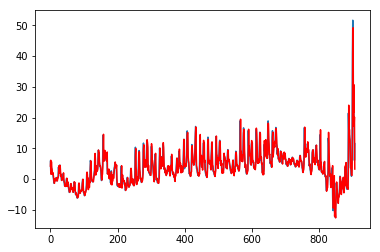

In [27]:
X = arima_target.values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test, color = 'blue')
pyplot.plot(predictions, color='red')
pyplot.show()

In [31]:
len(predictions)

907

In [30]:
len(test)

907

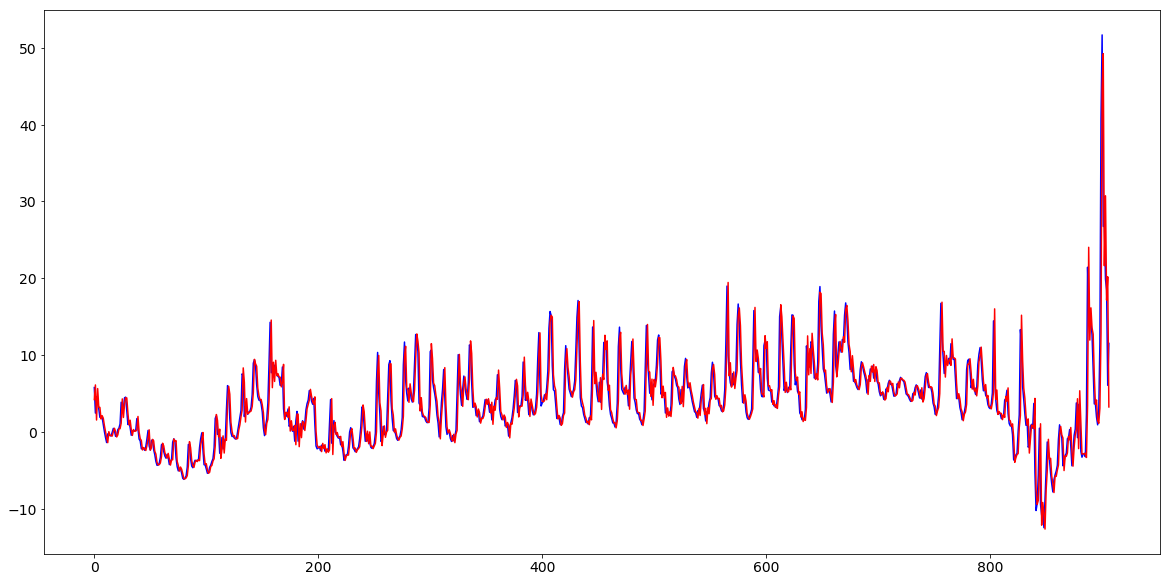

Test MSE: 7.143


In [47]:
# plot
plt.figure(figsize=(20,10))
pyplot.plot(test, color = 'blue')
pyplot.plot(predictions, color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
pyplot.show()

print('Test MSE: %.3f' % error)

In [41]:
test

array([[ 5.76327557e+00],
       [ 2.43815467e+00],
       [ 4.56560169e+00],
       [ 3.93524702e+00],
       [ 2.98971501e+00],
       [ 1.88659433e+00],
       [ 1.88659433e+00],
       [ 1.85507659e+00],
       [ 9.56821182e-01],
       [ 5.85657707e-02],
       [-7.29377572e-01],
       [-1.39124998e+00],
       [-2.72370433e-01],
       [-2.56611566e-01],
       [-4.92994569e-01],
       [-5.40271170e-01],
       [-6.75051641e-02],
       [ 4.52537442e-01],
       [ 1.53118972e-01],
       [-5.87547770e-01],
       [-5.08753436e-01],
       [ 2.79189907e-01],
       [ 4.84055176e-01],
       [ 1.01985665e+00],
       [ 3.85645268e+00],
       [ 2.56422560e+00],
       [ 3.08426821e+00],
       [ 4.42377189e+00],
       [ 4.51832509e+00],
       [ 2.80060860e+00],
       [ 9.56821182e-01],
       [ 1.24048079e+00],
       [ 5.62849510e-01],
       [-4.45717969e-01],
       [ 9.00835044e-02],
       [ 1.84636706e-01],
       [ 9.00835044e-02],
       [ 2.00395572e-01],
       [ 1.7

In [45]:

size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
xtick = list(arima_target[size:len(X)].index)
